In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from glob import glob
from keras.layers import *
from keras.models import *
from keras.utils import *
import numpy as np
import os

from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Input
from keras import layers
from keras.layers import Concatenate
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
from keras.utils import layer_utils
from keras.applications.imagenet_utils import preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs

Using TensorFlow backend.


# **Loading Training Files**

In [2]:
train_data = np.load('../input/cnn_draft/train_data.npy')
train_label = np.load('../input/cnn_draft/train_label.npy')
test_data = np.load('../input/cnn_draft/test_data.npy')
test_label = np.load('../input/cnn_draft/test_label.npy')
val_data = np.load('../input/cnn_draft/val_data.npy')
val_label = np.load('../input/cnn_draft/val_label.npy')


# Dealing with Class Imbalance

In [19]:
from sklearn.utils import class_weight
 
 
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_label),
                                                 train_label)
class_weights

array([1.29654487, 0.68722003, 1.29268897])

## Residual Unit

In [20]:
def Residual_Unit(input_tensor, nb_of_input_channels, max_dilation, number_of_units):
    
  for i in range(number_of_units):
    x1 = Conv2D(nb_of_input_channels*2, kernel_size = (1,1), strides = (1,1), padding='same', dilation_rate= (1,1), activation='relu')(input_tensor)
    x1 = BatchNormalization()(x1)
  
    a = []

    for i in range(1, max_dilation+1):
      temp = DepthwiseConv2D( kernel_size=(3,3), dilation_rate = (i,i), padding = 'same', activation= 'relu')(x1)
      temp = BatchNormalization()(temp)
      a.append(temp)

    x = Concatenate(axis= -1)(a)
    x = Conv2D(nb_of_input_channels, kernel_size = (1,1), strides = (1,1), padding='same', dilation_rate= (1,1), activation='relu')(x)
    x = BatchNormalization()(x)

    x = Add()([x, input_tensor])

    input_tensor = x
  
  return x


## Shifter Unit

In [21]:
# Shifter Unit:

def Shifter_Unit(input_tensor, nb_of_input_channels, max_dilation):
    x1 = Conv2D(nb_of_input_channels*4, kernel_size = (1,1), strides = (1,1), padding='same', dilation_rate= (1,1), activation='relu')(input_tensor)
    x1 = BatchNormalization()(x1)

    a = []

    for i in range(1, max_dilation+1):
      temp = DepthwiseConv2D( kernel_size=(3,3), dilation_rate = (i,i), padding = 'same', activation= 'relu')(x1)
      temp = MaxPool2D(pool_size=(2,2))(temp)
      temp = BatchNormalization()(temp)
      a.append(temp)

    x = Concatenate(axis= -1)(a)

    x = Conv2D(nb_of_input_channels*2, kernel_size = (1,1), strides = (1,1), padding='same', dilation_rate= (1,1), activation='relu')(x)
    x = BatchNormalization()(x)

    return x

# Network128

In [23]:
#Network:
  
def Network128(input_shape, nb_class, depth):
  xin = Input(shape= input_shape)

  x = Conv2D(16, kernel_size = (5,5), strides= (1,1), padding = 'same', activation='relu')(xin)
  x = BatchNormalization()(x)

  x = Conv2D(32, kernel_size = (3,3), strides= (2,2), padding = 'same', activation='relu')(x)
  x = BatchNormalization()(x)
  
##Max Dilation rate will be vary in the range (1,5). 

# Max Dilation rate is 5 for tensor (64x64x32)
  x = Residual_Unit(input_tensor=x, nb_of_input_channels=32, max_dilation=5, number_of_units=depth)
  x = Shifter_Unit(input_tensor=x, nb_of_input_channels=32, max_dilation=5)


# Max Dilation rate is 4 for (32x32x64)
  x = Residual_Unit(input_tensor=x, nb_of_input_channels=64, max_dilation=4, number_of_units=depth)
  x = Shifter_Unit(input_tensor=x, nb_of_input_channels=64, max_dilation=4)

# Max Dilation rate is 3 for (16x16x128)
  x = Residual_Unit(input_tensor=x, nb_of_input_channels=128, max_dilation=3, number_of_units=depth)
  x = Shifter_Unit(input_tensor=x, nb_of_input_channels=128, max_dilation=3)

# Max Dilation rate is 2 for (8x8x256)
  x = Residual_Unit(input_tensor=x, nb_of_input_channels=256, max_dilation=2, number_of_units=depth)

  x = GlobalAveragePooling2D()(x)

  x = Dense(128, activation='relu')(x)
  x = Dense(64, activation='relu')(x)

  x = Dense(nb_class, activation= 'softmax')(x)

  model = Model(xin, x)

  model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = 1e-3), metrics = ['accuracy'])

  return model

# Custom Callback

In [24]:
# plot confusion matrix

import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas.util.testing as tm
from sklearn import metrics
import seaborn as sns
sns.set()

plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          save = False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(b=False)
    if save == True:
      plt.savefig('Confusion Matrix.png', dpi = 900)

In [25]:
# test model performance
from datetime import datetime
import matplotlib.pyplot as plt


def test_model(model, test_generator, y_test, class_labels, cm_normalize=True, \
                 print_cm=True):
    
    # BS = 16
    results = dict()
    
    # n = len(testy)// BS

    # testX = testX[:BS*n]
    # testy = testy[:BS*n]

    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred_original = model.predict_generator(test_generator,verbose=1)
    # y_pred = (y_pred_original>0.5).astype('int')

    y_pred = np.argmax(y_pred_original, axis = 1)
    # y_test = np.argmax(testy, axis= 1)
    #y_test = np.argmax(testy, axis=-1)
    
    test_end_time = datetime.now()
    print('Done \n \n')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(HH:MM:SS:ms) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred
    y_test = y_test.astype(int) # sparse form not categorical
    

    # balanced_accuracy
    from sklearn.metrics import balanced_accuracy_score
    balanced_accuracy = balanced_accuracy_score(y_true=y_test, y_pred=y_pred)
    print('---------------------')
    print('| Balanced Accuracy  |')
    print('---------------------')
    print('\n    {}\n\n'.format(balanced_accuracy))

    
    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('---------------------')
    print('|      Accuracy      |')
    print('---------------------')
    print('\n    {}\n\n'.format(accuracy))
    

    # get classification report
    print('-------------------------')
    print('| Classifiction Report |')
    print('-------------------------')
    classification_report = metrics.classification_report(y_test, y_pred)
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('--------------------')
        print('| Confusion Matrix |')
        print('--------------------')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(6,4))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix')
    plt.show()
    

    
    # add the trained  model to the results
    results['model'] = model
    
    return


from keras.callbacks import Callback
class MyLogger(Callback):
  
  def __init__(self, test_generator, y_test, class_labels):
    super(MyLogger, self).__init__()
    self.test_generator = test_generator
    self.y_test = y_test
    self.class_labels = class_labels
    
  def on_epoch_end(self, epoch, logs=None):
    test_model(self.model, self.test_generator, self.y_test, self.class_labels)

# One Hot Encoding the labels

In [26]:
train_label = to_categorical(train_label, num_classes= 3)
test_label  = to_categorical(test_label, num_classes = 3)

# ImageDataGenerator

In [72]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import *


train_datagen = ImageDataGenerator(rescale = 1/255,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  fill_mode = 'constant',
                                  zoom_range = 0.2,
                                  rotation_range = 30)

val_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow(train_data,
                                     train_label, 
                                     batch_size = 16, 
                                     shuffle = True)

val_generator = val_datagen.flow(test_data,
                                 test_label,
                                 batch_size = 16,
                                 shuffle = False)

# Callback

In [30]:
os.mkdir('Model')
os.mkdir('History')

In [36]:
def get_callbacks():
    
    filepath = 'Model/best_model_multiclass_128.h5'
    callback1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callback2 = MyLogger(val_generator, 
                         y_test = np.argmax(test_label, axis = 1),
                         class_labels = ['Normal', 'COVID-19', 'Non-COVID'])
    
    callback3 = CSVLogger('History/Multiclass_Log_128.csv')

    return [callback1 ,callback2, callback3]

# Training

Epoch 1/70
326/326 [==============================] - 237s 726ms/step - loss: 0.6201 - accuracy: 0.7331 - val_loss: 1.1811 - val_accuracy: 0.7628

Epoch 00001: val_accuracy improved from -inf to 0.76282, saving model to Model/best_model_multiclass_128.h5
Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.278868


---------------------
| Balanced Accuracy  |
---------------------

    0.7182153545789909


---------------------
|      Accuracy      |
---------------------

    0.7628205128205128


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.69      0.91      0.79       234
           1       0.84      0.83      0.84       242
           2       0.80      0.41      0.54       148

    accuracy                           0.76       624
   macro avg       0.78      0.72      0.72       624
weighted avg       0.78   

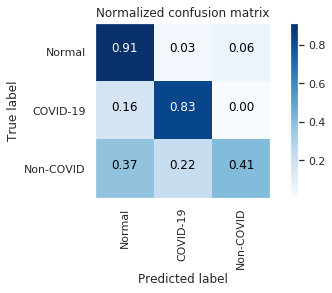

Epoch 2/70
326/326 [==============================] - 237s 726ms/step - loss: 0.6004 - accuracy: 0.7400 - val_loss: 1.3855 - val_accuracy: 0.7692

Epoch 00002: val_accuracy improved from 0.76282 to 0.76923, saving model to Model/best_model_multiclass_128.h5
Predicting test data
39/39 [==============================] - 5s 134ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.246952


---------------------
| Balanced Accuracy  |
---------------------

    0.7292095019367747


---------------------
|      Accuracy      |
---------------------

    0.7692307692307693


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.69      0.94      0.79       234
           1       0.87      0.81      0.84       242
           2       0.80      0.45      0.57       148

    accuracy                           0.77       624
   macro avg       0.79      0.73      0.73       624
weighted avg       0.79

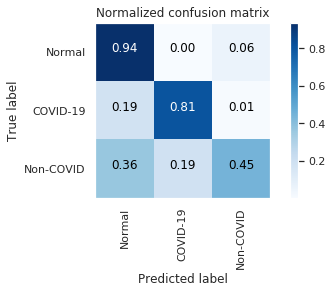

Epoch 3/70
326/326 [==============================] - 236s 725ms/step - loss: 0.5866 - accuracy: 0.7525 - val_loss: 1.1264 - val_accuracy: 0.8189

Epoch 00003: val_accuracy improved from 0.76923 to 0.81891, saving model to Model/best_model_multiclass_128.h5
Predicting test data
39/39 [==============================] - 5s 133ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.190627


---------------------
| Balanced Accuracy  |
---------------------

    0.7897430170157443


---------------------
|      Accuracy      |
---------------------

    0.8189102564102564


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       234
           1       0.76      0.97      0.85       242
           2       0.77      0.59      0.67       148

    accuracy                           0.82       624
   macro avg       0.82      0.79      0.80       624
weighted avg       0.83

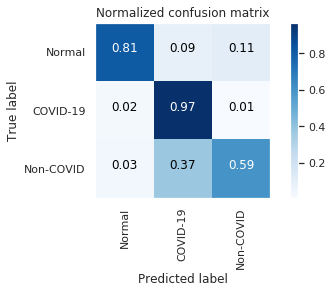

Epoch 4/70
326/326 [==============================] - 236s 724ms/step - loss: 0.5712 - accuracy: 0.7598 - val_loss: 0.8874 - val_accuracy: 0.8349

Epoch 00004: val_accuracy improved from 0.81891 to 0.83494, saving model to Model/best_model_multiclass_128.h5
Predicting test data
39/39 [==============================] - 5s 133ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.184233


---------------------
| Balanced Accuracy  |
---------------------

    0.8057848057848057


---------------------
|      Accuracy      |
---------------------

    0.8349358974358975


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       234
           1       0.83      0.95      0.89       242
           2       0.77      0.61      0.68       148

    accuracy                           0.83       624
   macro avg       0.82      0.81      0.81       624
weighted avg       0.83

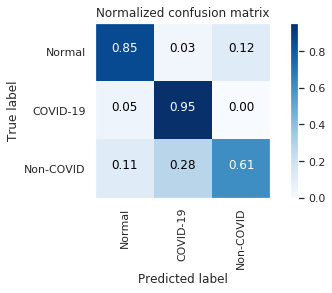

Epoch 5/70
326/326 [==============================] - 236s 723ms/step - loss: 0.5611 - accuracy: 0.7627 - val_loss: 0.9768 - val_accuracy: 0.8429

Epoch 00005: val_accuracy improved from 0.83494 to 0.84295, saving model to Model/best_model_multiclass_128.h5
Predicting test data
39/39 [==============================] - 5s 133ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.192109


---------------------
| Balanced Accuracy  |
---------------------

    0.8207808889627072


---------------------
|      Accuracy      |
---------------------

    0.842948717948718


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       234
           1       0.87      0.92      0.89       242
           2       0.79      0.67      0.72       148

    accuracy                           0.84       624
   macro avg       0.83      0.82      0.83       624
weighted avg       0.84 

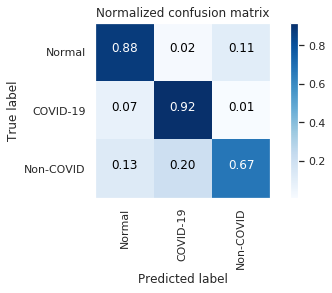

Epoch 6/70
326/326 [==============================] - 236s 723ms/step - loss: 0.5434 - accuracy: 0.7676 - val_loss: 1.2230 - val_accuracy: 0.8269

Epoch 00006: val_accuracy did not improve from 0.84295
Predicting test data
39/39 [==============================] - 5s 133ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.178877


---------------------
| Balanced Accuracy  |
---------------------

    0.7893414711596529


---------------------
|      Accuracy      |
---------------------

    0.8269230769230769


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.77      0.94      0.85       234
           1       0.87      0.90      0.89       242
           2       0.87      0.53      0.66       148

    accuracy                           0.83       624
   macro avg       0.84      0.79      0.80       624
weighted avg       0.83      0.83      0.82       624

--------------------
| C

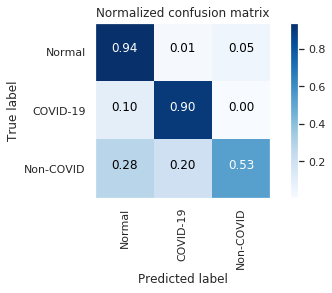

Epoch 7/70
326/326 [==============================] - 236s 723ms/step - loss: 0.5412 - accuracy: 0.7726 - val_loss: 0.9146 - val_accuracy: 0.8686

Epoch 00007: val_accuracy improved from 0.84295 to 0.86859, saving model to Model/best_model_multiclass_128.h5
Predicting test data
39/39 [==============================] - 5s 133ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.192886


---------------------
| Balanced Accuracy  |
---------------------

    0.8509284872921237


---------------------
|      Accuracy      |
---------------------

    0.8685897435897436


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       234
           1       0.89      0.93      0.91       242
           2       0.81      0.73      0.77       148

    accuracy                           0.87       624
   macro avg       0.86      0.85      0.85       624
weighted avg       0.87

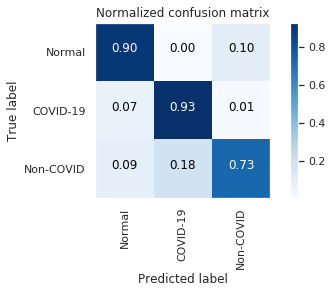

Epoch 8/70
326/326 [==============================] - 236s 725ms/step - loss: 0.5433 - accuracy: 0.7711 - val_loss: 1.0176 - val_accuracy: 0.8125

Epoch 00008: val_accuracy did not improve from 0.86859
Predicting test data
39/39 [==============================] - 5s 133ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.196453


---------------------
| Balanced Accuracy  |
---------------------

    0.7770389588571408


---------------------
|      Accuracy      |
---------------------

    0.8125


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.73      0.95      0.82       234
           1       0.90      0.86      0.88       242
           2       0.89      0.53      0.66       148

    accuracy                           0.81       624
   macro avg       0.84      0.78      0.79       624
weighted avg       0.83      0.81      0.81       624

--------------------
| Confusion Mat

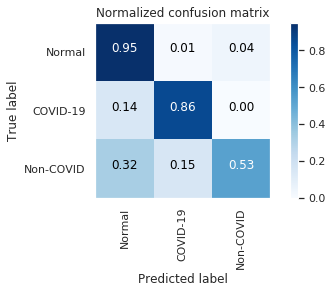

Epoch 9/70
326/326 [==============================] - 237s 726ms/step - loss: 0.5270 - accuracy: 0.7799 - val_loss: 0.8416 - val_accuracy: 0.8061

Epoch 00009: val_accuracy did not improve from 0.86859
Predicting test data
39/39 [==============================] - 5s 134ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.223569


---------------------
| Balanced Accuracy  |
---------------------

    0.8009913919004829


---------------------
|      Accuracy      |
---------------------

    0.8060897435897436


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       234
           1       0.95      0.72      0.82       242
           2       0.73      0.76      0.74       148

    accuracy                           0.81       624
   macro avg       0.81      0.80      0.80       624
weighted avg       0.82      0.81      0.81       624

--------------------
| C

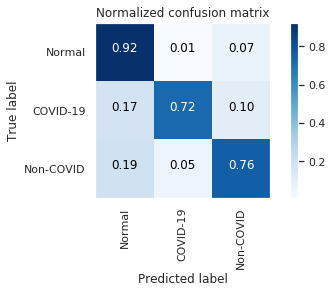

Epoch 10/70
326/326 [==============================] - 237s 726ms/step - loss: 0.5295 - accuracy: 0.7717 - val_loss: 2.1355 - val_accuracy: 0.7788

Epoch 00010: val_accuracy did not improve from 0.86859
Predicting test data
39/39 [==============================] - 5s 134ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.240371


---------------------
| Balanced Accuracy  |
---------------------

    0.7212757894576076


---------------------
|      Accuracy      |
---------------------

    0.7788461538461539


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.68      0.97      0.80       234
           1       0.89      0.87      0.88       242
           2       0.92      0.32      0.47       148

    accuracy                           0.78       624
   macro avg       0.83      0.72      0.72       624
weighted avg       0.82      0.78      0.75       624

--------------------
| 

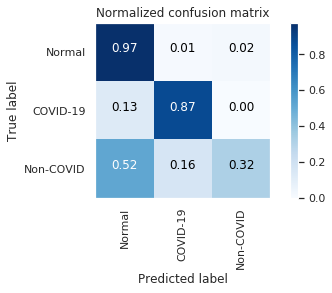

Epoch 11/70
326/326 [==============================] - 237s 726ms/step - loss: 0.5257 - accuracy: 0.7742 - val_loss: 0.6373 - val_accuracy: 0.8558

Epoch 00011: val_accuracy did not improve from 0.86859
Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.261657


---------------------
| Balanced Accuracy  |
---------------------

    0.8370963143690417


---------------------
|      Accuracy      |
---------------------

    0.8557692307692307


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       234
           1       0.86      0.92      0.89       242
           2       0.80      0.71      0.75       148

    accuracy                           0.86       624
   macro avg       0.85      0.84      0.84       624
weighted avg       0.85      0.86      0.85       624

--------------------
| 

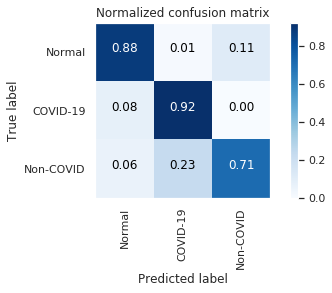

Epoch 12/70
326/326 [==============================] - 237s 727ms/step - loss: 0.5145 - accuracy: 0.7786 - val_loss: 1.3295 - val_accuracy: 0.7933

Epoch 00012: val_accuracy did not improve from 0.86859
Predicting test data
39/39 [==============================] - 5s 134ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.225367


---------------------
| Balanced Accuracy  |
---------------------

    0.7456377229104502


---------------------
|      Accuracy      |
---------------------

    0.7932692307692307


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.69      0.95      0.80       234
           1       0.91      0.88      0.89       242
           2       0.86      0.41      0.56       148

    accuracy                           0.79       624
   macro avg       0.82      0.75      0.75       624
weighted avg       0.82      0.79      0.78       624

--------------------
| 

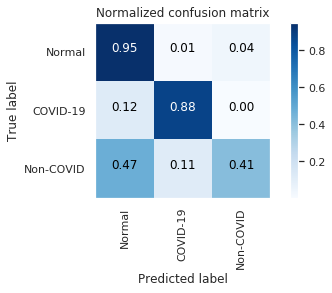

Epoch 13/70
326/326 [==============================] - 237s 726ms/step - loss: 0.5113 - accuracy: 0.7845 - val_loss: 0.7813 - val_accuracy: 0.8381

Epoch 00013: val_accuracy did not improve from 0.86859
Predicting test data
39/39 [==============================] - 5s 134ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.213168


---------------------
| Balanced Accuracy  |
---------------------

    0.8112583339856068


---------------------
|      Accuracy      |
---------------------

    0.8381410256410257


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       234
           1       0.80      0.94      0.87       242
           2       0.79      0.63      0.70       148

    accuracy                           0.84       624
   macro avg       0.83      0.81      0.82       624
weighted avg       0.84      0.84      0.83       624

--------------------
| 

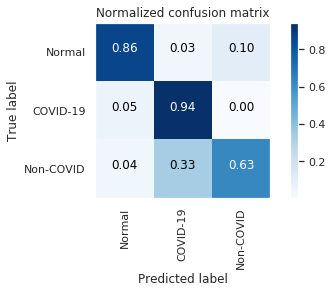

Epoch 14/70
326/326 [==============================] - 237s 726ms/step - loss: 0.5112 - accuracy: 0.7784 - val_loss: 0.6754 - val_accuracy: 0.8782

Epoch 00014: val_accuracy improved from 0.86859 to 0.87821, saving model to Model/best_model_multiclass_128.h5
Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.261925


---------------------
| Balanced Accuracy  |
---------------------

    0.8672820945548217


---------------------
|      Accuracy      |
---------------------

    0.8782051282051282


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       234
           1       0.86      0.97      0.91       242
           2       0.81      0.80      0.80       148

    accuracy                           0.88       624
   macro avg       0.87      0.87      0.87       624
weighted avg       0.8

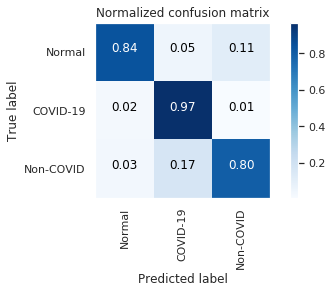

Epoch 15/70
326/326 [==============================] - 236s 725ms/step - loss: 0.4960 - accuracy: 0.7882 - val_loss: 0.6299 - val_accuracy: 0.8349

Epoch 00015: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 133ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.185116


---------------------
| Balanced Accuracy  |
---------------------

    0.8174674992856811


---------------------
|      Accuracy      |
---------------------

    0.8349358974358975


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.94      0.80      0.87       234
           1       0.80      0.95      0.87       242
           2       0.75      0.70      0.72       148

    accuracy                           0.83       624
   macro avg       0.83      0.82      0.82       624
weighted avg       0.84      0.83      0.83       624

--------------------
| 

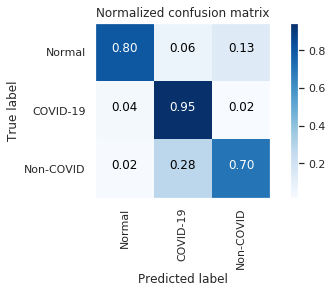

Epoch 16/70
326/326 [==============================] - 237s 726ms/step - loss: 0.5007 - accuracy: 0.7803 - val_loss: 0.7164 - val_accuracy: 0.7965

Epoch 00016: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 134ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.251001


---------------------
| Balanced Accuracy  |
---------------------

    0.777155572610118


---------------------
|      Accuracy      |
---------------------

    0.7964743589743589


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.96      0.70      0.81       234
           1       0.76      0.98      0.85       242
           2       0.69      0.66      0.67       148

    accuracy                           0.80       624
   macro avg       0.80      0.78      0.78       624
weighted avg       0.82      0.80      0.79       624

--------------------
| C

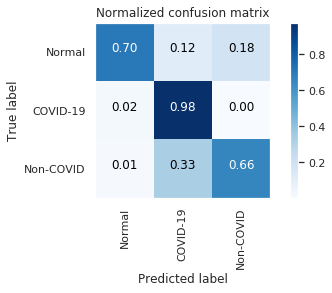

Epoch 17/70
326/326 [==============================] - 236s 725ms/step - loss: 0.5024 - accuracy: 0.7836 - val_loss: 0.6950 - val_accuracy: 0.8670

Epoch 00017: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.276031


---------------------
| Balanced Accuracy  |
---------------------

    0.8441607532516623


---------------------
|      Accuracy      |
---------------------

    0.8669871794871795


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.93      0.88      0.91       234
           1       0.83      0.96      0.89       242
           2       0.85      0.69      0.76       148

    accuracy                           0.87       624
   macro avg       0.87      0.84      0.85       624
weighted avg       0.87      0.87      0.86       624

--------------------
| 

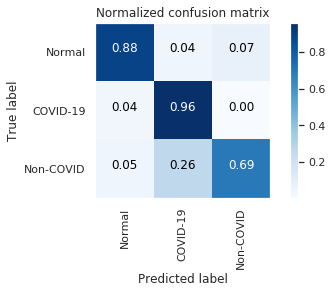

Epoch 18/70
326/326 [==============================] - 236s 725ms/step - loss: 0.4974 - accuracy: 0.7864 - val_loss: 0.7190 - val_accuracy: 0.8349

Epoch 00018: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 134ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.229549


---------------------
| Balanced Accuracy  |
---------------------

    0.8001789138152775


---------------------
|      Accuracy      |
---------------------

    0.8349358974358975


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       234
           1       0.81      0.94      0.87       242
           2       0.86      0.56      0.68       148

    accuracy                           0.83       624
   macro avg       0.84      0.80      0.81       624
weighted avg       0.84      0.83      0.83       624

--------------------
| 

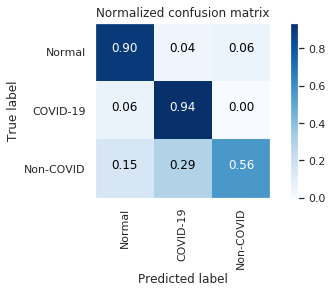

Epoch 19/70
326/326 [==============================] - 237s 727ms/step - loss: 0.4963 - accuracy: 0.7908 - val_loss: 1.0236 - val_accuracy: 0.8269

Epoch 00019: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 134ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.231707


---------------------
| Balanced Accuracy  |
---------------------

    0.7893414711596529


---------------------
|      Accuracy      |
---------------------

    0.8269230769230769


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.77      0.94      0.85       234
           1       0.88      0.90      0.89       242
           2       0.87      0.53      0.66       148

    accuracy                           0.83       624
   macro avg       0.84      0.79      0.80       624
weighted avg       0.83      0.83      0.82       624

--------------------
| 

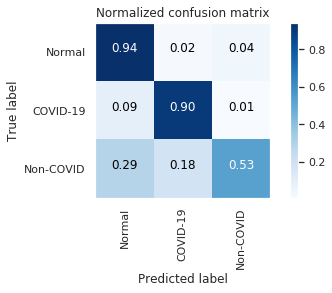

Epoch 20/70
326/326 [==============================] - 237s 727ms/step - loss: 0.4840 - accuracy: 0.7897 - val_loss: 1.0777 - val_accuracy: 0.8333

Epoch 00020: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 136ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.298793


---------------------
| Balanced Accuracy  |
---------------------

    0.7978795706068432


---------------------
|      Accuracy      |
---------------------

    0.8333333333333334


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       234
           1       0.80      0.94      0.87       242
           2       0.83      0.55      0.66       148

    accuracy                           0.83       624
   macro avg       0.83      0.80      0.81       624
weighted avg       0.83      0.83      0.83       624

--------------------
| 

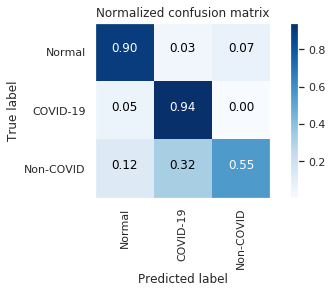

Epoch 21/70
326/326 [==============================] - 237s 728ms/step - loss: 0.4772 - accuracy: 0.7958 - val_loss: 0.9399 - val_accuracy: 0.8237

Epoch 00021: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 134ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.219383


---------------------
| Balanced Accuracy  |
---------------------

    0.7910822456277001


---------------------
|      Accuracy      |
---------------------

    0.8237179487179487


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       234
           1       0.79      0.93      0.86       242
           2       0.82      0.57      0.67       148

    accuracy                           0.82       624
   macro avg       0.82      0.79      0.80       624
weighted avg       0.83      0.82      0.82       624

--------------------
| 

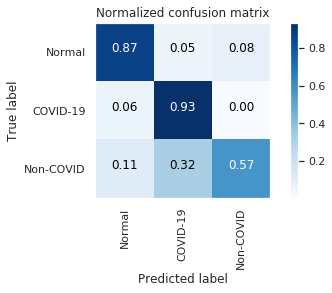

Epoch 22/70
326/326 [==============================] - 237s 728ms/step - loss: 0.4794 - accuracy: 0.7939 - val_loss: 1.7717 - val_accuracy: 0.7196

Epoch 00022: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.289827


---------------------
| Balanced Accuracy  |
---------------------

    0.641186482095573


---------------------
|      Accuracy      |
---------------------

    0.719551282051282


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       234
           1       0.64      0.95      0.77       242
           2       0.71      0.10      0.18       148

    accuracy                           0.72       624
   macro avg       0.73      0.64      0.60       624
weighted avg       0.73      0.72      0.66       624

--------------------
| Co

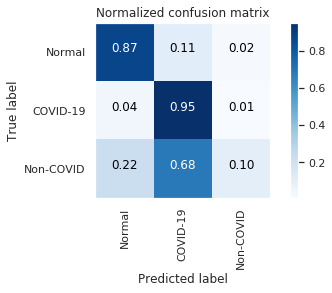

Epoch 23/70
326/326 [==============================] - 237s 727ms/step - loss: 0.4760 - accuracy: 0.7918 - val_loss: 0.5570 - val_accuracy: 0.8638

Epoch 00023: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 137ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.328227


---------------------
| Balanced Accuracy  |
---------------------

    0.8514802151165788


---------------------
|      Accuracy      |
---------------------

    0.8637820512820513


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       234
           1       0.83      0.94      0.88       242
           2       0.81      0.77      0.79       148

    accuracy                           0.86       624
   macro avg       0.86      0.85      0.85       624
weighted avg       0.87      0.86      0.86       624

--------------------
| 

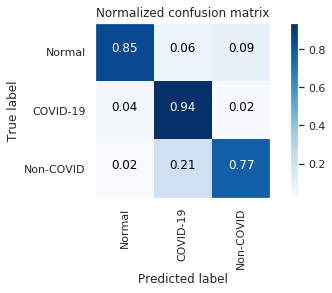

Epoch 24/70
326/326 [==============================] - 237s 727ms/step - loss: 0.4668 - accuracy: 0.7949 - val_loss: 0.4690 - val_accuracy: 0.7372

Epoch 00024: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.278996


---------------------
| Balanced Accuracy  |
---------------------

    0.756117051571597


---------------------
|      Accuracy      |
---------------------

    0.7371794871794872


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       234
           1       0.93      0.52      0.67       242
           2       0.49      0.87      0.63       148

    accuracy                           0.74       624
   macro avg       0.78      0.76      0.73       624
weighted avg       0.82      0.74      0.74       624

--------------------
| C

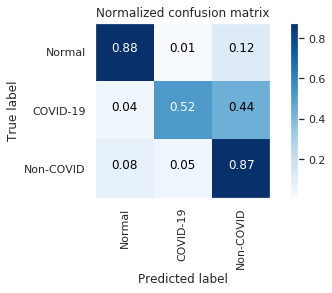

Epoch 25/70
326/326 [==============================] - 237s 728ms/step - loss: 0.4762 - accuracy: 0.7972 - val_loss: 0.7492 - val_accuracy: 0.8333

Epoch 00025: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 136ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.306396


---------------------
| Balanced Accuracy  |
---------------------

    0.8110294019384928


---------------------
|      Accuracy      |
---------------------

    0.8333333333333334


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       234
           1       0.78      0.95      0.86       242
           2       0.78      0.66      0.72       148

    accuracy                           0.83       624
   macro avg       0.84      0.81      0.82       624
weighted avg       0.84      0.83      0.83       624

--------------------
| 

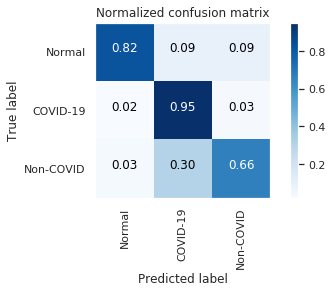

Epoch 26/70
326/326 [==============================] - 237s 727ms/step - loss: 0.4800 - accuracy: 0.7924 - val_loss: 1.0877 - val_accuracy: 0.8189

Epoch 00026: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 136ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.303909


---------------------
| Balanced Accuracy  |
---------------------

    0.7714383168928624


---------------------
|      Accuracy      |
---------------------

    0.8189102564102564


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       234
           1       0.75      0.98      0.85       242
           2       0.80      0.45      0.57       148

    accuracy                           0.82       624
   macro avg       0.82      0.77      0.78       624
weighted avg       0.83      0.82      0.80       624

--------------------
| 

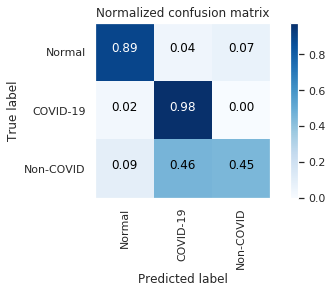

Epoch 27/70
326/326 [==============================] - 237s 727ms/step - loss: 0.4655 - accuracy: 0.7991 - val_loss: 0.6914 - val_accuracy: 0.8750

Epoch 00027: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.253419


---------------------
| Balanced Accuracy  |
---------------------

    0.853436876164149


---------------------
|      Accuracy      |
---------------------

    0.875


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       234
           1       0.82      0.99      0.90       242
           2       0.85      0.71      0.77       148

    accuracy                           0.88       624
   macro avg       0.88      0.85      0.86       624
weighted avg       0.88      0.88      0.87       624

--------------------
| Confusion Matr

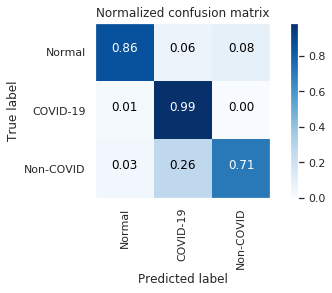

Epoch 28/70
326/326 [==============================] - 237s 728ms/step - loss: 0.4565 - accuracy: 0.8054 - val_loss: 0.6267 - val_accuracy: 0.8205

Epoch 00028: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 136ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.289433


---------------------
| Balanced Accuracy  |
---------------------

    0.8087386496477406


---------------------
|      Accuracy      |
---------------------

    0.8205128205128205


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.97      0.74      0.84       234
           1       0.83      0.95      0.89       242
           2       0.64      0.74      0.69       148

    accuracy                           0.82       624
   macro avg       0.82      0.81      0.80       624
weighted avg       0.84      0.82      0.82       624

--------------------
| 

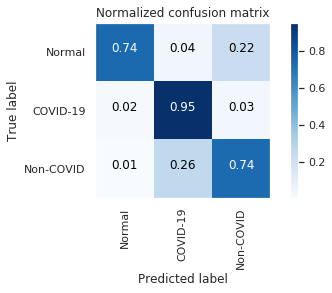

Epoch 29/70
326/326 [==============================] - 237s 727ms/step - loss: 0.4578 - accuracy: 0.8008 - val_loss: 0.7217 - val_accuracy: 0.8590

Epoch 00029: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.254685


---------------------
| Balanced Accuracy  |
---------------------

    0.8425698425698426


---------------------
|      Accuracy      |
---------------------

    0.8589743589743589


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       234
           1       0.86      0.91      0.88       242
           2       0.82      0.73      0.77       148

    accuracy                           0.86       624
   macro avg       0.85      0.84      0.85       624
weighted avg       0.86      0.86      0.86       624

--------------------
| 

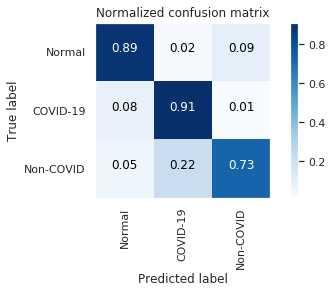

Epoch 30/70
326/326 [==============================] - 237s 727ms/step - loss: 0.4450 - accuracy: 0.8077 - val_loss: 0.2901 - val_accuracy: 0.8253

Epoch 00030: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 136ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.325403


---------------------
| Balanced Accuracy  |
---------------------

    0.829606943243307


---------------------
|      Accuracy      |
---------------------

    0.8253205128205128


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.97      0.83      0.89       234
           1       0.90      0.80      0.85       242
           2       0.61      0.86      0.71       148

    accuracy                           0.83       624
   macro avg       0.83      0.83      0.82       624
weighted avg       0.86      0.83      0.83       624

--------------------
| C

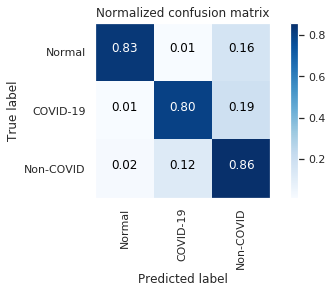

Epoch 31/70
326/326 [==============================] - 237s 728ms/step - loss: 0.4521 - accuracy: 0.8066 - val_loss: 0.7306 - val_accuracy: 0.8686

Epoch 00031: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.267434


---------------------
| Balanced Accuracy  |
---------------------

    0.8481155981155982


---------------------
|      Accuracy      |
---------------------

    0.8685897435897436


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       234
           1       0.85      0.95      0.90       242
           2       0.83      0.71      0.76       148

    accuracy                           0.87       624
   macro avg       0.86      0.85      0.85       624
weighted avg       0.87      0.87      0.87       624

--------------------
| 

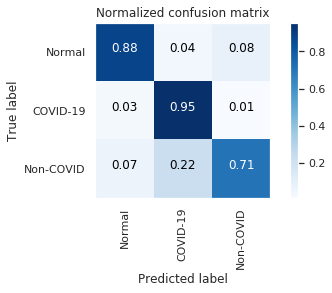

Epoch 32/70
326/326 [==============================] - 237s 728ms/step - loss: 0.4588 - accuracy: 0.8062 - val_loss: 1.1378 - val_accuracy: 0.8269

Epoch 00032: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 134ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.236383


---------------------
| Balanced Accuracy  |
---------------------

    0.786744150380514


---------------------
|      Accuracy      |
---------------------

    0.8269230769230769


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       234
           1       0.75      0.98      0.85       242
           2       0.88      0.51      0.65       148

    accuracy                           0.83       624
   macro avg       0.85      0.79      0.80       624
weighted avg       0.84      0.83      0.82       624

--------------------
| C

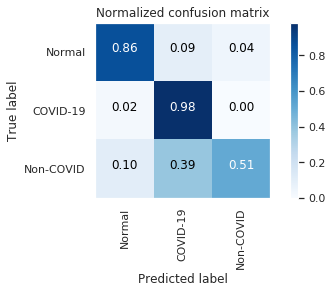

Epoch 33/70
326/326 [==============================] - 237s 727ms/step - loss: 0.4518 - accuracy: 0.8129 - val_loss: 0.4998 - val_accuracy: 0.8782

Epoch 00033: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 136ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.319939


---------------------
| Balanced Accuracy  |
---------------------

    0.8648459330277513


---------------------
|      Accuracy      |
---------------------

    0.8782051282051282


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       234
           1       0.85      0.96      0.90       242
           2       0.80      0.78      0.79       148

    accuracy                           0.88       624
   macro avg       0.87      0.86      0.87       624
weighted avg       0.88      0.88      0.88       624

--------------------
| 

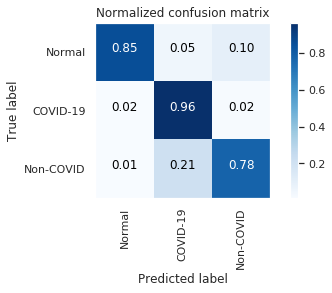

Epoch 34/70
326/326 [==============================] - 237s 727ms/step - loss: 0.4352 - accuracy: 0.8158 - val_loss: 0.2872 - val_accuracy: 0.8253

Epoch 00034: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 134ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.238595


---------------------
| Balanced Accuracy  |
---------------------

    0.8300579664216028


---------------------
|      Accuracy      |
---------------------

    0.8253205128205128


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.97      0.79      0.87       234
           1       0.88      0.83      0.86       242
           2       0.62      0.86      0.73       148

    accuracy                           0.83       624
   macro avg       0.83      0.83      0.82       624
weighted avg       0.86      0.83      0.83       624

--------------------
| 

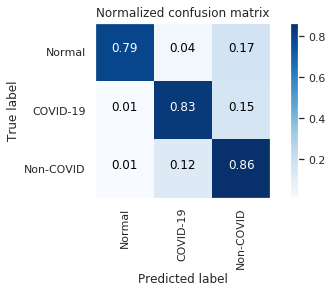

Epoch 35/70
326/326 [==============================] - 237s 728ms/step - loss: 0.4410 - accuracy: 0.8148 - val_loss: 0.3769 - val_accuracy: 0.8526

Epoch 00035: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 134ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.232535


---------------------
| Balanced Accuracy  |
---------------------

    0.847161688070779


---------------------
|      Accuracy      |
---------------------

    0.8525641025641025


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.97      0.77      0.86       234
           1       0.86      0.95      0.90       242
           2       0.72      0.82      0.76       148

    accuracy                           0.85       624
   macro avg       0.85      0.85      0.84       624
weighted avg       0.87      0.85      0.85       624

--------------------
| C

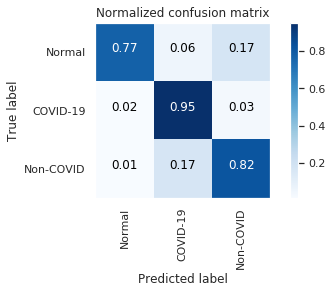

Epoch 36/70
326/326 [==============================] - 237s 727ms/step - loss: 0.4338 - accuracy: 0.8140 - val_loss: 0.7595 - val_accuracy: 0.8670

Epoch 00036: val_accuracy did not improve from 0.87821
Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.272960


---------------------
| Balanced Accuracy  |
---------------------

    0.8390058844604299


---------------------
|      Accuracy      |
---------------------

    0.8669871794871795


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       234
           1       0.84      0.98      0.90       242
           2       0.86      0.65      0.74       148

    accuracy                           0.87       624
   macro avg       0.87      0.84      0.85       624
weighted avg       0.87      0.87      0.86       624

--------------------
| 

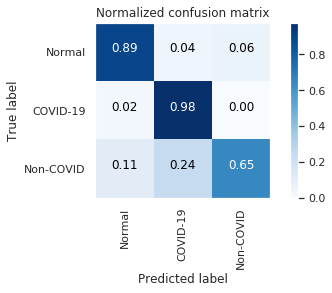

Epoch 37/70
326/326 [==============================] - 237s 727ms/step - loss: 0.4295 - accuracy: 0.8202 - val_loss: 0.6600 - val_accuracy: 0.8798

Epoch 00037: val_accuracy improved from 0.87821 to 0.87981, saving model to Model/best_model_multiclass_128.h5
Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.279394


---------------------
| Balanced Accuracy  |
---------------------

    0.8694872558508923


---------------------
|      Accuracy      |
---------------------

    0.8798076923076923


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       234
           1       0.86      0.97      0.91       242
           2       0.80      0.80      0.80       148

    accuracy                           0.88       624
   macro avg       0.87      0.87      0.87       624
weighted avg       0.8

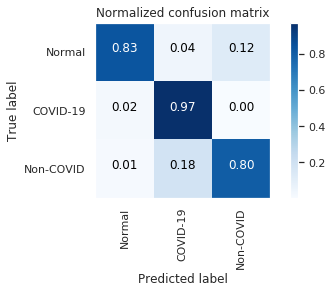

Epoch 38/70
326/326 [==============================] - 237s 727ms/step - loss: 0.4281 - accuracy: 0.8188 - val_loss: 0.6960 - val_accuracy: 0.8814

Epoch 00038: val_accuracy improved from 0.87981 to 0.88141, saving model to Model/best_model_multiclass_128.h5
Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.263961


---------------------
| Balanced Accuracy  |
---------------------

    0.8687581414854142


---------------------
|      Accuracy      |
---------------------

    0.8814102564102564


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       234
           1       0.88      0.94      0.91       242
           2       0.82      0.78      0.80       148

    accuracy                           0.88       624
   macro avg       0.87      0.87      0.87       624
weighted avg       0.8

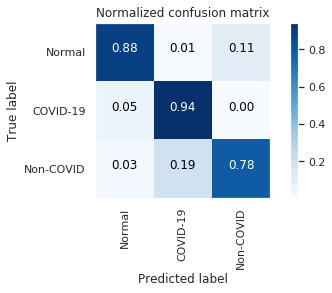

Epoch 39/70
326/326 [==============================] - 237s 727ms/step - loss: 0.4324 - accuracy: 0.8160 - val_loss: 0.4441 - val_accuracy: 0.8494

Epoch 00039: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.256161


---------------------
| Balanced Accuracy  |
---------------------

    0.8513783968329424


---------------------
|      Accuracy      |
---------------------

    0.8493589743589743


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       234
           1       0.92      0.84      0.88       242
           2       0.71      0.86      0.78       148

    accuracy                           0.85       624
   macro avg       0.84      0.85      0.84       624
weighted avg       0.86      0.85      0.85       624

--------------------
| 

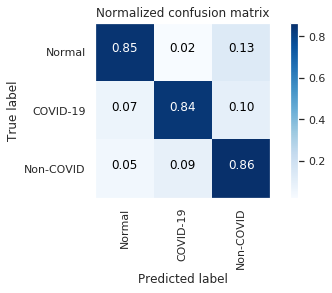

Epoch 40/70
326/326 [==============================] - 237s 727ms/step - loss: 0.4181 - accuracy: 0.8221 - val_loss: 0.7611 - val_accuracy: 0.8670

Epoch 00040: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 5s 137ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.332211


---------------------
| Balanced Accuracy  |
---------------------

    0.847256188165279


---------------------
|      Accuracy      |
---------------------

    0.8669871794871795


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       234
           1       0.90      0.90      0.90       242
           2       0.83      0.71      0.77       148

    accuracy                           0.87       624
   macro avg       0.86      0.85      0.85       624
weighted avg       0.87      0.87      0.86       624

--------------------
| C

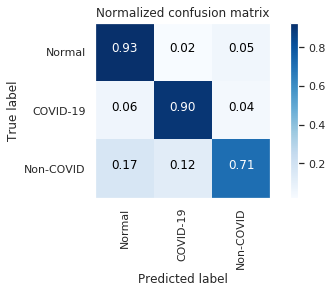

Epoch 41/70
326/326 [==============================] - 237s 728ms/step - loss: 0.4033 - accuracy: 0.8271 - val_loss: 0.9920 - val_accuracy: 0.8189

Epoch 00041: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 5s 134ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.221454


---------------------
| Balanced Accuracy  |
---------------------

    0.7904294949749495


---------------------
|      Accuracy      |
---------------------

    0.8189102564102564


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.98      0.79      0.87       234
           1       0.73      0.98      0.84       242
           2       0.81      0.60      0.69       148

    accuracy                           0.82       624
   macro avg       0.84      0.79      0.80       624
weighted avg       0.84      0.82      0.82       624

--------------------
| 

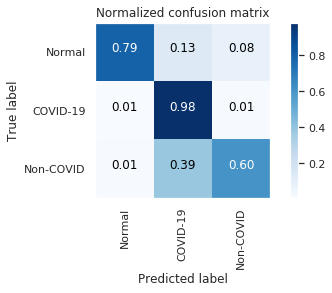

Epoch 42/70
326/326 [==============================] - 237s 728ms/step - loss: 0.4091 - accuracy: 0.8227 - val_loss: 0.4971 - val_accuracy: 0.8718

Epoch 00042: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.264279


---------------------
| Balanced Accuracy  |
---------------------

    0.8635420226329317


---------------------
|      Accuracy      |
---------------------

    0.8717948717948718


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       234
           1       0.91      0.87      0.89       242
           2       0.81      0.80      0.81       148

    accuracy                           0.87       624
   macro avg       0.86      0.86      0.86       624
weighted avg       0.87      0.87      0.87       624

--------------------
| 

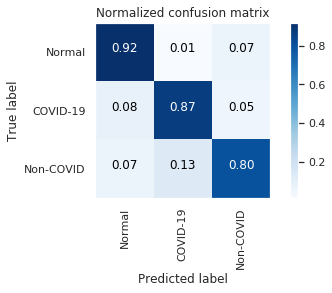

Epoch 43/70
326/326 [==============================] - 237s 728ms/step - loss: 0.4031 - accuracy: 0.8276 - val_loss: 0.4335 - val_accuracy: 0.8846

Epoch 00043: val_accuracy improved from 0.88141 to 0.88462, saving model to Model/best_model_multiclass_128.h5
Predicting test data
39/39 [==============================] - 5s 134ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.245008


---------------------
| Balanced Accuracy  |
---------------------

    0.8759813532540806


---------------------
|      Accuracy      |
---------------------

    0.8846153846153846


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       234
           1       0.91      0.92      0.92       242
           2       0.78      0.82      0.80       148

    accuracy                           0.88       624
   macro avg       0.87      0.88      0.87       624
weighted avg       0.8

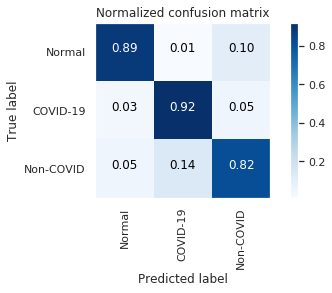

Epoch 44/70
326/326 [==============================] - 237s 727ms/step - loss: 0.3993 - accuracy: 0.8278 - val_loss: 0.7453 - val_accuracy: 0.8349

Epoch 00044: val_accuracy did not improve from 0.88462
Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.277020


---------------------
| Balanced Accuracy  |
---------------------

    0.8025679843861662


---------------------
|      Accuracy      |
---------------------

    0.8349358974358975


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       234
           1       0.77      0.95      0.85       242
           2       0.89      0.58      0.70       148

    accuracy                           0.83       624
   macro avg       0.85      0.80      0.81       624
weighted avg       0.85      0.83      0.83       624

--------------------
| 

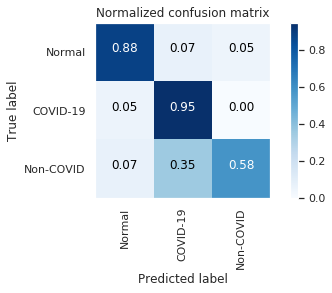

Epoch 45/70
326/326 [==============================] - 237s 727ms/step - loss: 0.3903 - accuracy: 0.8321 - val_loss: 0.4570 - val_accuracy: 0.9054

Epoch 00045: val_accuracy improved from 0.88462 to 0.90545, saving model to Model/best_model_multiclass_128.h5
Predicting test data
39/39 [==============================] - 5s 136ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.300188


---------------------
| Balanced Accuracy  |
---------------------

    0.8981677163495346


---------------------
|      Accuracy      |
---------------------

    0.905448717948718


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       234
           1       0.91      0.96      0.93       242
           2       0.83      0.85      0.84       148

    accuracy                           0.91       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.91

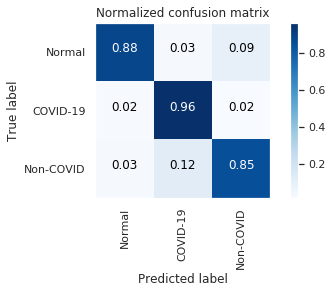

Epoch 46/70
326/326 [==============================] - 237s 727ms/step - loss: 0.3863 - accuracy: 0.8299 - val_loss: 0.5980 - val_accuracy: 0.8462

Epoch 00046: val_accuracy did not improve from 0.90545
Predicting test data
39/39 [==============================] - 5s 136ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.308332


---------------------
| Balanced Accuracy  |
---------------------

    0.8147600874873602


---------------------
|      Accuracy      |
---------------------

    0.8461538461538461


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       234
           1       0.92      0.90      0.91       242
           2       0.79      0.59      0.68       148

    accuracy                           0.85       624
   macro avg       0.84      0.81      0.82       624
weighted avg       0.85      0.85      0.84       624

--------------------
| 

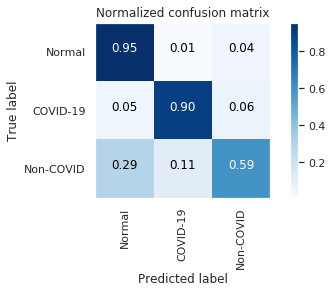

Epoch 47/70
326/326 [==============================] - 237s 727ms/step - loss: 0.3931 - accuracy: 0.8342 - val_loss: 0.5313 - val_accuracy: 0.9022

Epoch 00047: val_accuracy did not improve from 0.90545
Predicting test data
39/39 [==============================] - 5s 134ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.234810


---------------------
| Balanced Accuracy  |
---------------------

    0.8886496159223433


---------------------
|      Accuracy      |
---------------------

    0.9022435897435898


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       234
           1       0.88      0.97      0.92       242
           2       0.88      0.80      0.84       148

    accuracy                           0.90       624
   macro avg       0.90      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624

--------------------
| 

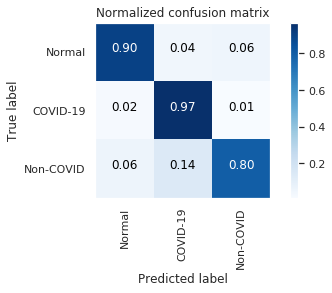

Epoch 48/70
326/326 [==============================] - 237s 727ms/step - loss: 0.3778 - accuracy: 0.8384 - val_loss: 0.4894 - val_accuracy: 0.8574

Epoch 00048: val_accuracy did not improve from 0.90545
Predicting test data
39/39 [==============================] - 5s 134ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.243215


---------------------
| Balanced Accuracy  |
---------------------

    0.8489990308172127


---------------------
|      Accuracy      |
---------------------

    0.8573717948717948


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.96      0.80      0.88       234
           1       0.87      0.95      0.91       242
           2       0.72      0.80      0.75       148

    accuracy                           0.86       624
   macro avg       0.85      0.85      0.85       624
weighted avg       0.87      0.86      0.86       624

--------------------
| 

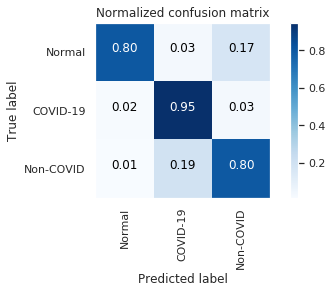

Epoch 49/70
326/326 [==============================] - 237s 726ms/step - loss: 0.3794 - accuracy: 0.8328 - val_loss: 0.5338 - val_accuracy: 0.8301

Epoch 00049: val_accuracy did not improve from 0.90545
Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.277582


---------------------
| Balanced Accuracy  |
---------------------

    0.8324876052148779


---------------------
|      Accuracy      |
---------------------

    0.8301282051282052


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.97      0.79      0.87       234
           1       0.87      0.85      0.86       242
           2       0.64      0.85      0.73       148

    accuracy                           0.83       624
   macro avg       0.83      0.83      0.82       624
weighted avg       0.85      0.83      0.84       624

--------------------
| 

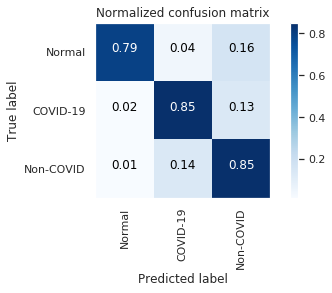

Epoch 50/70
326/326 [==============================] - 237s 727ms/step - loss: 0.3799 - accuracy: 0.8386 - val_loss: 0.4632 - val_accuracy: 0.8782

Epoch 00050: val_accuracy did not improve from 0.90545
Predicting test data
39/39 [==============================] - 5s 134ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.231000


---------------------
| Balanced Accuracy  |
---------------------

    0.8677059131604586


---------------------
|      Accuracy      |
---------------------

    0.8782051282051282


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       234
           1       0.88      0.93      0.90       242
           2       0.77      0.80      0.78       148

    accuracy                           0.88       624
   macro avg       0.87      0.87      0.87       624
weighted avg       0.88      0.88      0.88       624

--------------------
| 

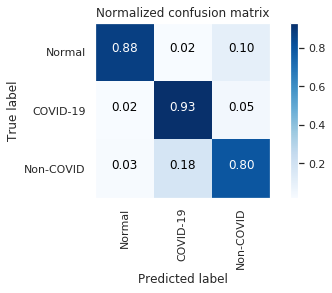

Epoch 51/70
326/326 [==============================] - 237s 728ms/step - loss: 0.3760 - accuracy: 0.8370 - val_loss: 1.1636 - val_accuracy: 0.8670

Epoch 00051: val_accuracy did not improve from 0.90545
Predicting test data
39/39 [==============================] - 5s 134ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.220443


---------------------
| Balanced Accuracy  |
---------------------

    0.829900625355171


---------------------
|      Accuracy      |
---------------------

    0.8669871794871795


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       234
           1       0.85      0.98      0.91       242
           2       0.91      0.57      0.71       148

    accuracy                           0.87       624
   macro avg       0.88      0.83      0.84       624
weighted avg       0.87      0.87      0.86       624

--------------------
| C

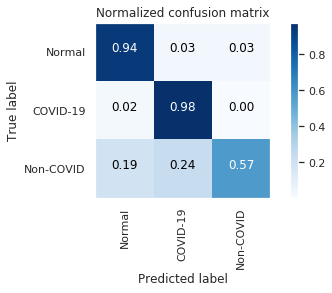

Epoch 52/70
326/326 [==============================] - 237s 728ms/step - loss: 0.3713 - accuracy: 0.8401 - val_loss: 0.6373 - val_accuracy: 0.8846

Epoch 00052: val_accuracy did not improve from 0.90545
Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.269935


---------------------
| Balanced Accuracy  |
---------------------

    0.8729058047239867


---------------------
|      Accuracy      |
---------------------

    0.8846153846153846


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       234
           1       0.93      0.90      0.92       242
           2       0.84      0.79      0.82       148

    accuracy                           0.88       624
   macro avg       0.88      0.87      0.88       624
weighted avg       0.89      0.88      0.88       624

--------------------
| 

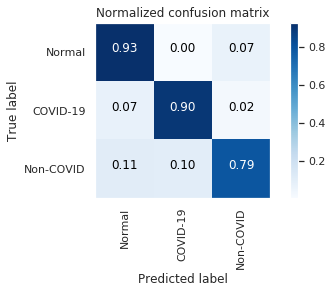

Epoch 53/70
326/326 [==============================] - 237s 727ms/step - loss: 0.3596 - accuracy: 0.8484 - val_loss: 1.0252 - val_accuracy: 0.8638

Epoch 00053: val_accuracy did not improve from 0.90545
Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.274668


---------------------
| Balanced Accuracy  |
---------------------

    0.8354233126960399


---------------------
|      Accuracy      |
---------------------

    0.8637820512820513


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       234
           1       0.83      0.97      0.89       242
           2       0.84      0.64      0.73       148

    accuracy                           0.86       624
   macro avg       0.86      0.84      0.84       624
weighted avg       0.87      0.86      0.86       624

--------------------
| 

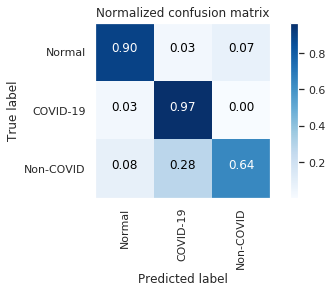

Epoch 54/70
326/326 [==============================] - 237s 728ms/step - loss: 0.3619 - accuracy: 0.8388 - val_loss: 0.5354 - val_accuracy: 0.8686

Epoch 00054: val_accuracy did not improve from 0.90545
Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.276591


---------------------
| Balanced Accuracy  |
---------------------

    0.8611911339184067


---------------------
|      Accuracy      |
---------------------

    0.8685897435897436


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       234
           1       0.87      0.90      0.88       242
           2       0.75      0.81      0.78       148

    accuracy                           0.87       624
   macro avg       0.86      0.86      0.86       624
weighted avg       0.87      0.87      0.87       624

--------------------
| 

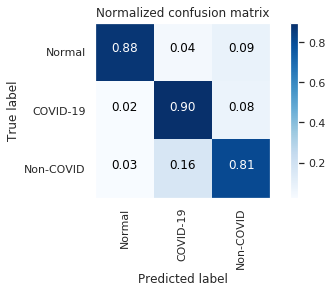

Epoch 55/70
326/326 [==============================] - 237s 727ms/step - loss: 0.3525 - accuracy: 0.8478 - val_loss: 0.5720 - val_accuracy: 0.8061

Epoch 00055: val_accuracy did not improve from 0.90545
Predicting test data
39/39 [==============================] - 5s 136ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.308515


---------------------
| Balanced Accuracy  |
---------------------

    0.7975663202935931


---------------------
|      Accuracy      |
---------------------

    0.8060897435897436


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       234
           1       0.78      0.81      0.79       242
           2       0.64      0.74      0.68       148

    accuracy                           0.81       624
   macro avg       0.80      0.80      0.80       624
weighted avg       0.82      0.81      0.81       624

--------------------
| 

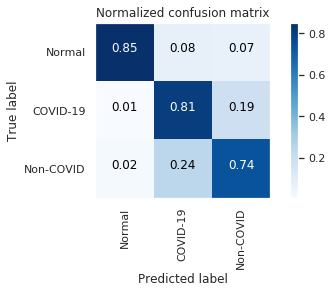

Epoch 56/70
326/326 [==============================] - 237s 727ms/step - loss: 0.3566 - accuracy: 0.8491 - val_loss: 0.1965 - val_accuracy: 0.8574

Epoch 00056: val_accuracy did not improve from 0.90545
Predicting test data
39/39 [==============================] - 5s 137ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.356556


---------------------
| Balanced Accuracy  |
---------------------

    0.864793273884183


---------------------
|      Accuracy      |
---------------------

    0.8573717948717948


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.97      0.81      0.88       234
           1       0.93      0.87      0.90       242
           2       0.66      0.92      0.77       148

    accuracy                           0.86       624
   macro avg       0.86      0.86      0.85       624
weighted avg       0.88      0.86      0.86       624

--------------------
| C

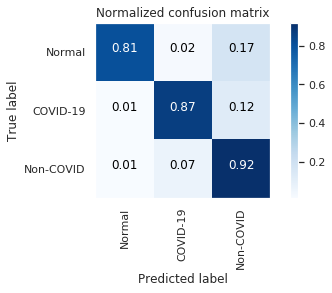

Epoch 57/70
326/326 [==============================] - 237s 728ms/step - loss: 0.3506 - accuracy: 0.8466 - val_loss: 0.5287 - val_accuracy: 0.8942

Epoch 00057: val_accuracy did not improve from 0.90545
Predicting test data
39/39 [==============================] - 5s 136ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.295774


---------------------
| Balanced Accuracy  |
---------------------

    0.8800599709690619


---------------------
|      Accuracy      |
---------------------

    0.8942307692307693


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       234
           1       0.88      0.95      0.92       242
           2       0.84      0.78      0.81       148

    accuracy                           0.89       624
   macro avg       0.89      0.88      0.88       624
weighted avg       0.89      0.89      0.89       624

--------------------
| 

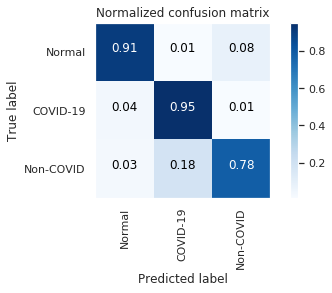

Epoch 58/70
326/326 [==============================] - 237s 727ms/step - loss: 0.3368 - accuracy: 0.8553 - val_loss: 0.5360 - val_accuracy: 0.8942

Epoch 00058: val_accuracy did not improve from 0.90545
Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.257458


---------------------
| Balanced Accuracy  |
---------------------

    0.88001288001288


---------------------
|      Accuracy      |
---------------------

    0.8942307692307693


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       234
           1       0.89      0.95      0.92       242
           2       0.83      0.78      0.81       148

    accuracy                           0.89       624
   macro avg       0.89      0.88      0.88       624
weighted avg       0.89      0.89      0.89       624

--------------------
| Co

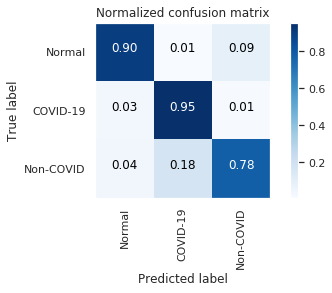

Epoch 59/70
326/326 [==============================] - 237s 727ms/step - loss: 0.3417 - accuracy: 0.8558 - val_loss: 0.8656 - val_accuracy: 0.8798

Epoch 00059: val_accuracy did not improve from 0.90545
Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.281940


---------------------
| Balanced Accuracy  |
---------------------

    0.8603349057894513


---------------------
|      Accuracy      |
---------------------

    0.8798076923076923


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       234
           1       0.85      0.98      0.91       242
           2       0.83      0.73      0.78       148

    accuracy                           0.88       624
   macro avg       0.88      0.86      0.87       624
weighted avg       0.88      0.88      0.88       624

--------------------
| 

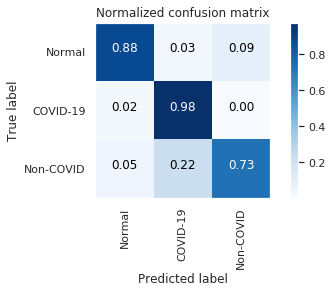

Epoch 60/70
 26/326 [=>............................] - ETA: 3:33 - loss: 0.3547 - accuracy: 0.8197

KeyboardInterrupt: 

In [37]:
model = Network128(input_shape = (128, 128, 1), nb_class = 3, depth = 5)
history = model.fit_generator(train_generator,
                              steps_per_epoch = len(train_data) // 16,
                              validation_data=val_generator,
                              validation_steps= len(test_data)// 16,
                              class_weight =class_weights,
                              epochs = 70,
                              callbacks = get_callbacks(),
                              verbose = 1
                              )

# Loading Best Model

In [38]:
from keras.models import load_model
best_model = load_model('/kaggle/working/Model/best_model_multiclass_128.h5')

# Best Model Performance

Predicting test data
39/39 [==============================] - 5s 135ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:05.268048


---------------------
| Balanced Accuracy  |
---------------------

    0.8981677163495346


---------------------
|      Accuracy      |
---------------------

    0.905448717948718


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       234
           1       0.91      0.96      0.93       242
           2       0.83      0.85      0.84       148

    accuracy                           0.91       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624

--------------------
| Confusion Matrix |
--------------------

 [[206   6  22]
 [  5 233   4]
 [  4  18 126]]


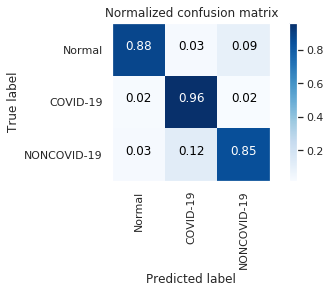

In [40]:
test_model(best_model, 
           val_generator,
           y_test = np.argmax(test_label, axis = 1),
           class_labels = ['Normal', 'COVID-19', 'NONCOVID-19'])

# Plotting EpochPlot

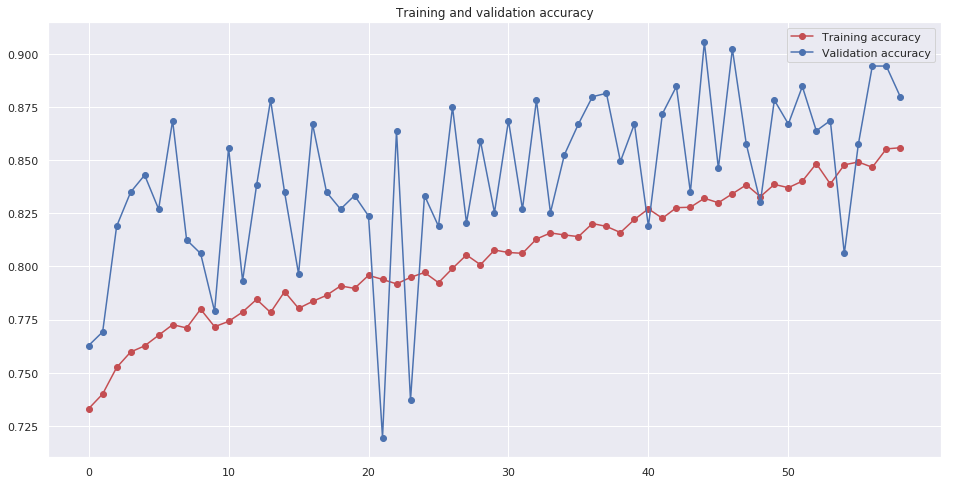

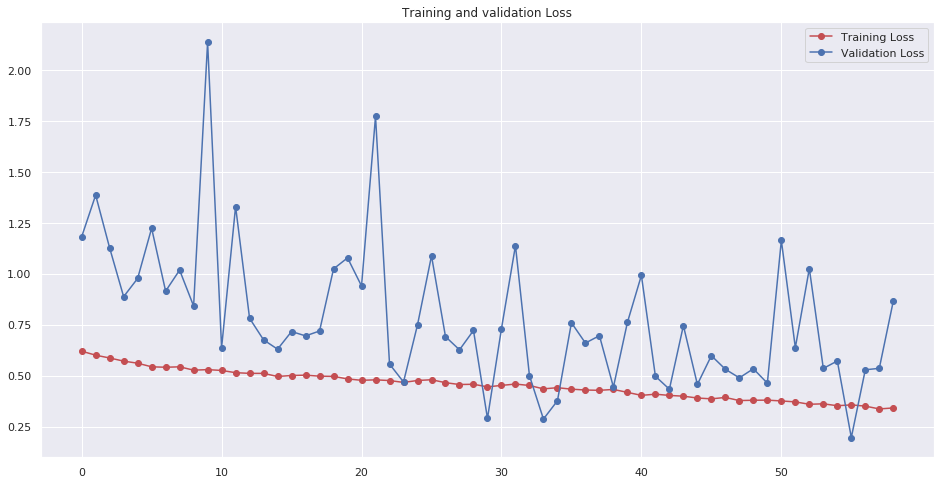

<Figure size 432x288 with 0 Axes>

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(0,len(acc))
fig = plt.gcf()
fig.set_size_inches(16, 8)

plt.plot(epochs, acc, 'r', label='Training accuracy',marker = "o")
plt.plot(epochs, val_acc, 'b', label='Validation accuracy',marker = "o")
plt.title('Training and validation accuracy')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
plt.figure()

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Training and validation Loss')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()


# RESNET50



In [74]:
from keras.applications import ResNet50

In [120]:
NUM_CLASSES = 3
IMAGE_SIZE = 128
CHANNELS = 1
resnet_weights_path = '/kaggle/input/keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet_model = ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = resnet_weights_path)

ipt = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="input")
x = Concatenate()([ipt, ipt, ipt])

x = resnet_model(x)

predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)

full_model = Model(inputs=ipt, outputs=predictions)
full_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Epoch 1/70
326/326 [==============================] - 39s 120ms/step - loss: 0.7942 - accuracy: 0.6430 - val_loss: 1.0986 - val_accuracy: 0.4327

Epoch 00001: val_accuracy improved from -inf to 0.43269, saving model to Model/best_model_multiclass_128.h5
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.092824


---------------------
| Balanced Accuracy  |
---------------------

    0.3828730192366556


---------------------
|      Accuracy      |
---------------------

    0.4326923076923077


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.40      1.00      0.57       234
           1       0.82      0.15      0.26       242
           2       0.00      0.00      0.00       148

    accuracy                           0.43       624
   macro avg       0.41      0.38      0.28       624
weighted avg       0.47     

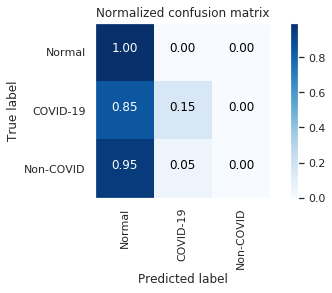

Epoch 2/70
326/326 [==============================] - 39s 119ms/step - loss: 0.7673 - accuracy: 0.6434 - val_loss: 2.0937 - val_accuracy: 0.3654

Epoch 00002: val_accuracy did not improve from 0.43269
Predicting test data
39/39 [==============================] - 1s 29ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.121847


---------------------
| Balanced Accuracy  |
---------------------

    0.3162157707612253


---------------------
|      Accuracy      |
---------------------

    0.36538461538461536


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.39      0.20      0.26       234
           1       0.36      0.75      0.49       242
           2       0.00      0.00      0.00       148

    accuracy                           0.37       624
   macro avg       0.25      0.32      0.25       624
weighted avg       0.29      0.37      0.29       624

--------------------
| Co

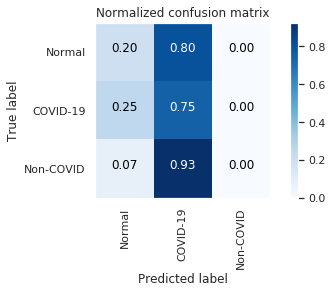

Epoch 3/70
326/326 [==============================] - 38s 118ms/step - loss: 0.7499 - accuracy: 0.6400 - val_loss: 16.1181 - val_accuracy: 0.3782

Epoch 00003: val_accuracy did not improve from 0.43269
Predicting test data
39/39 [==============================] - 1s 29ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.118037


---------------------
| Balanced Accuracy  |
---------------------

    0.3359939723576087


---------------------
|      Accuracy      |
---------------------

    0.3782051282051282


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.38      0.99      0.55       234
           1       0.57      0.02      0.03       242
           2       0.00      0.00      0.00       148

    accuracy                           0.38       624
   macro avg       0.32      0.34      0.19       624
weighted avg       0.36      0.38      0.22       624

--------------------
| Co

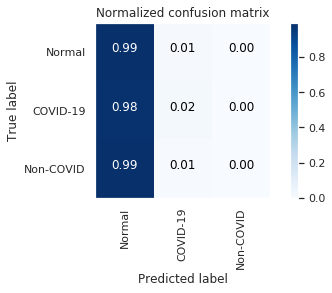

Epoch 4/70
326/326 [==============================] - 39s 121ms/step - loss: 0.7228 - accuracy: 0.6712 - val_loss: 1.2814 - val_accuracy: 0.6859

Epoch 00004: val_accuracy improved from 0.43269 to 0.68590, saving model to Model/best_model_multiclass_128.h5
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.110984


---------------------
| Balanced Accuracy  |
---------------------

    0.6114529978166342


---------------------
|      Accuracy      |
---------------------

    0.6858974358974359


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.62      0.96      0.75       234
           1       0.77      0.79      0.78       242
           2       0.93      0.09      0.16       148

    accuracy                           0.69       624
   macro avg       0.77      0.61      0.56       624
weighted avg       0.75  

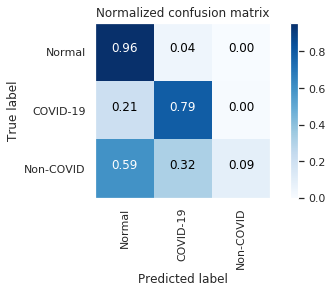

Epoch 5/70
326/326 [==============================] - 39s 119ms/step - loss: 0.6900 - accuracy: 0.6804 - val_loss: 0.6835 - val_accuracy: 0.4920

Epoch 00005: val_accuracy did not improve from 0.68590
Predicting test data
39/39 [==============================] - 1s 29ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.133433


---------------------
| Balanced Accuracy  |
---------------------

    0.5274420956239138


---------------------
|      Accuracy      |
---------------------

    0.49198717948717946


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.04      0.08       234
           1       0.85      0.74      0.79       242
           2       0.29      0.80      0.43       148

    accuracy                           0.49       624
   macro avg       0.72      0.53      0.43       624
weighted avg       0.77      0.49      0.44       624

--------------------
| Co

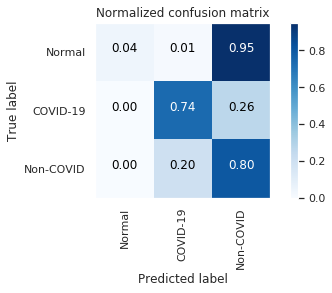

Epoch 6/70
326/326 [==============================] - 39s 118ms/step - loss: 0.6666 - accuracy: 0.6998 - val_loss: 0.8033 - val_accuracy: 0.7388

Epoch 00006: val_accuracy improved from 0.68590 to 0.73878, saving model to Model/best_model_multiclass_128.h5
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.106982


---------------------
| Balanced Accuracy  |
---------------------

    0.7146816237725329


---------------------
|      Accuracy      |
---------------------

    0.7387820512820513


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.90      0.72      0.80       234
           1       0.75      0.87      0.80       242
           2       0.52      0.55      0.54       148

    accuracy                           0.74       624
   macro avg       0.73      0.71      0.72       624
weighted avg       0.75  

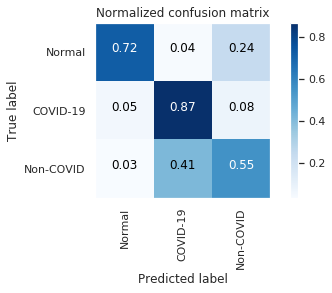

Epoch 7/70
326/326 [==============================] - 39s 119ms/step - loss: 0.6805 - accuracy: 0.6923 - val_loss: 1.2663 - val_accuracy: 0.4952

Epoch 00007: val_accuracy did not improve from 0.73878
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.093402


---------------------
| Balanced Accuracy  |
---------------------

    0.43057170329897604


---------------------
|      Accuracy      |
---------------------

    0.4951923076923077


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.97      0.29      0.45       234
           1       0.43      0.99      0.60       242
           2       0.50      0.01      0.03       148

    accuracy                           0.50       624
   macro avg       0.64      0.43      0.36       624
weighted avg       0.65      0.50      0.41       624

--------------------
| Co

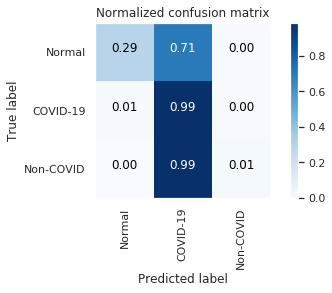

Epoch 8/70
326/326 [==============================] - 39s 118ms/step - loss: 0.6003 - accuracy: 0.7442 - val_loss: 0.8017 - val_accuracy: 0.7692

Epoch 00008: val_accuracy improved from 0.73878 to 0.76923, saving model to Model/best_model_multiclass_128.h5
Predicting test data
39/39 [==============================] - 1s 27ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.075547


---------------------
| Balanced Accuracy  |
---------------------

    0.7392440119712846


---------------------
|      Accuracy      |
---------------------

    0.7692307692307693


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.92      0.74      0.82       234
           1       0.71      0.94      0.81       242
           2       0.67      0.54      0.60       148

    accuracy                           0.77       624
   macro avg       0.77      0.74      0.74       624
weighted avg       0.78  

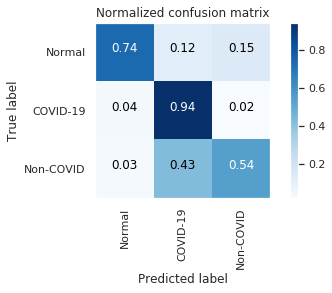

Epoch 9/70
326/326 [==============================] - 39s 118ms/step - loss: 0.5584 - accuracy: 0.7611 - val_loss: 0.3161 - val_accuracy: 0.6490

Epoch 00009: val_accuracy did not improve from 0.76923
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.093688


---------------------
| Balanced Accuracy  |
---------------------

    0.676364062727699


---------------------
|      Accuracy      |
---------------------

    0.6490384615384616


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.98      0.35      0.52       234
           1       0.90      0.79      0.84       242
           2       0.40      0.89      0.55       148

    accuracy                           0.65       624
   macro avg       0.76      0.68      0.64       624
weighted avg       0.81      0.65      0.65       624

--------------------
| Conf

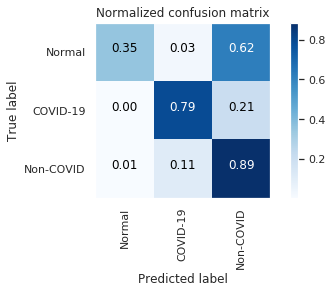

Epoch 10/70
326/326 [==============================] - 39s 119ms/step - loss: 0.5547 - accuracy: 0.7621 - val_loss: 1.3269 - val_accuracy: 0.5946

Epoch 00010: val_accuracy did not improve from 0.76923
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.085824


---------------------
| Balanced Accuracy  |
---------------------

    0.5452825680098408


---------------------
|      Accuracy      |
---------------------

    0.594551282051282


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.50      0.97      0.66       234
           1       0.88      0.49      0.63       242
           2       0.68      0.18      0.29       148

    accuracy                           0.59       624
   macro avg       0.69      0.55      0.53       624
weighted avg       0.69      0.59      0.56       624

--------------------
| Con

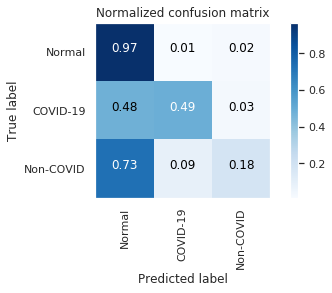

Epoch 11/70
326/326 [==============================] - 39s 120ms/step - loss: 0.5513 - accuracy: 0.7571 - val_loss: 0.8543 - val_accuracy: 0.7997

Epoch 00011: val_accuracy improved from 0.76923 to 0.79968, saving model to Model/best_model_multiclass_128.h5
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.096718


---------------------
| Balanced Accuracy  |
---------------------

    0.7695190422463148


---------------------
|      Accuracy      |
---------------------

    0.7996794871794872


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.73      0.95      0.82       234
           1       0.93      0.81      0.86       242
           2       0.76      0.55      0.64       148

    accuracy                           0.80       624
   macro avg       0.80      0.77      0.78       624
weighted avg       0.81 

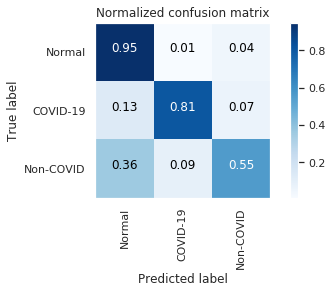

Epoch 12/70
326/326 [==============================] - 39s 118ms/step - loss: 0.5347 - accuracy: 0.7663 - val_loss: 11.5646 - val_accuracy: 0.5176

Epoch 00012: val_accuracy did not improve from 0.79968
Predicting test data
39/39 [==============================] - 1s 29ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.129293


---------------------
| Balanced Accuracy  |
---------------------

    0.45578159214522856


---------------------
|      Accuracy      |
---------------------

    0.5176282051282052


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.45      0.99      0.62       234
           1       0.85      0.38      0.53       242
           2       0.00      0.00      0.00       148

    accuracy                           0.52       624
   macro avg       0.43      0.46      0.38       624
weighted avg       0.50      0.52      0.43       624

--------------------
| 

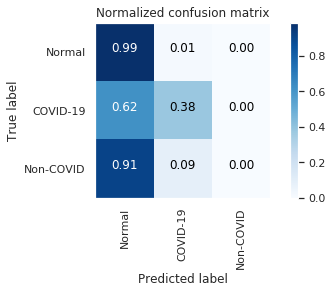

Epoch 13/70
326/326 [==============================] - 39s 118ms/step - loss: 0.5291 - accuracy: 0.7680 - val_loss: 0.4986 - val_accuracy: 0.8494

Epoch 00013: val_accuracy improved from 0.79968 to 0.84936, saving model to Model/best_model_multiclass_128.h5
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.083090


---------------------
| Balanced Accuracy  |
---------------------

    0.8422731377276831


---------------------
|      Accuracy      |
---------------------

    0.8493589743589743


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       234
           1       0.90      0.84      0.87       242
           2       0.68      0.79      0.73       148

    accuracy                           0.85       624
   macro avg       0.84      0.84      0.84       624
weighted avg       0.86 

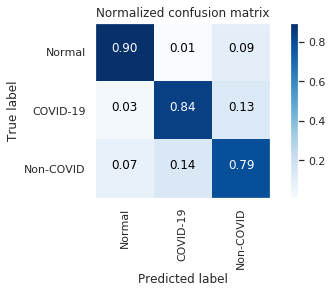

Epoch 14/70
326/326 [==============================] - 39s 121ms/step - loss: 0.5109 - accuracy: 0.7793 - val_loss: 0.3095 - val_accuracy: 0.7019

Epoch 00014: val_accuracy did not improve from 0.84936
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.088779


---------------------
| Balanced Accuracy  |
---------------------

    0.7265622265622266


---------------------
|      Accuracy      |
---------------------

    0.7019230769230769


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      0.55      0.71       234
           1       0.91      0.73      0.81       242
           2       0.44      0.91      0.60       148

    accuracy                           0.70       624
   macro avg       0.78      0.73      0.70       624
weighted avg       0.83      0.70      0.72       624

--------------------
| Co

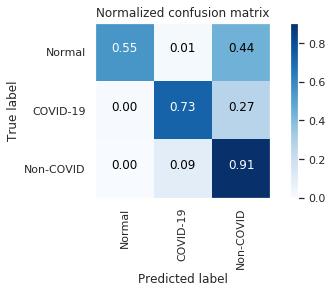

Epoch 15/70
326/326 [==============================] - 38s 118ms/step - loss: 0.5194 - accuracy: 0.7749 - val_loss: 4.1377 - val_accuracy: 0.6779

Epoch 00015: val_accuracy did not improve from 0.84936
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.108082


---------------------
| Balanced Accuracy  |
---------------------

    0.5948955948955948


---------------------
|      Accuracy      |
---------------------

    0.6778846153846154


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.58      0.95      0.72       234
           1       0.84      0.82      0.83       242
           2       1.00      0.01      0.03       148

    accuracy                           0.68       624
   macro avg       0.81      0.59      0.52       624
weighted avg       0.78      0.68      0.60       624

--------------------
| Co

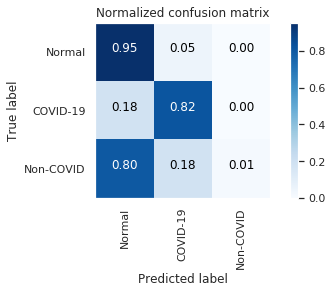

Epoch 16/70
326/326 [==============================] - 39s 118ms/step - loss: 0.5119 - accuracy: 0.7784 - val_loss: 1.3985 - val_accuracy: 0.8029

Epoch 00016: val_accuracy did not improve from 0.84936
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.098127


---------------------
| Balanced Accuracy  |
---------------------

    0.7478253841890204


---------------------
|      Accuracy      |
---------------------

    0.8028846153846154


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       234
           1       0.79      0.93      0.85       242
           2       0.89      0.36      0.52       148

    accuracy                           0.80       624
   macro avg       0.82      0.75      0.75       624
weighted avg       0.82      0.80      0.78       624

--------------------
| Co

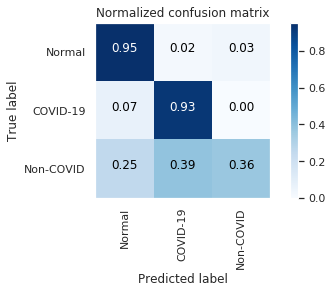

Epoch 17/70
326/326 [==============================] - 39s 119ms/step - loss: 0.4974 - accuracy: 0.7778 - val_loss: 7.1826 - val_accuracy: 0.5609

Epoch 00017: val_accuracy did not improve from 0.84936
Predicting test data
39/39 [==============================] - 1s 30ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.181948


---------------------
| Balanced Accuracy  |
---------------------

    0.4930187657460385


---------------------
|      Accuracy      |
---------------------

    0.5608974358974359


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.47      0.99      0.64       234
           1       0.89      0.49      0.63       242
           2       0.00      0.00      0.00       148

    accuracy                           0.56       624
   macro avg       0.46      0.49      0.42       624
weighted avg       0.52      0.56      0.48       624

--------------------
| Co

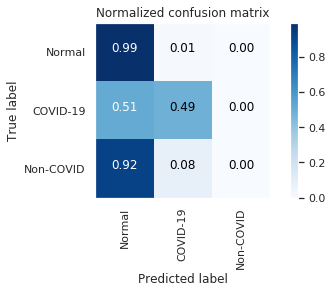

Epoch 18/70
326/326 [==============================] - 39s 118ms/step - loss: 0.4900 - accuracy: 0.7812 - val_loss: 0.7747 - val_accuracy: 0.8814

Epoch 00018: val_accuracy improved from 0.84936 to 0.88141, saving model to Model/best_model_multiclass_128.h5
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.099012


---------------------
| Balanced Accuracy  |
---------------------

    0.8646664783028419


---------------------
|      Accuracy      |
---------------------

    0.8814102564102564


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       234
           1       0.88      0.94      0.91       242
           2       0.79      0.75      0.77       148

    accuracy                           0.88       624
   macro avg       0.87      0.86      0.87       624
weighted avg       0.88 

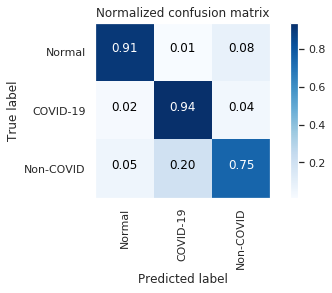

Epoch 19/70
326/326 [==============================] - 38s 118ms/step - loss: 0.5032 - accuracy: 0.7776 - val_loss: 8.6654 - val_accuracy: 0.4920

Epoch 00019: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 1s 27ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.079863


---------------------
| Balanced Accuracy  |
---------------------

    0.4338372065644793


---------------------
|      Accuracy      |
---------------------

    0.49198717948717946


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.43      1.00      0.60       234
           1       0.87      0.31      0.45       242
           2       0.00      0.00      0.00       148

    accuracy                           0.49       624
   macro avg       0.43      0.43      0.35       624
weighted avg       0.50      0.49      0.40       624

--------------------
| C

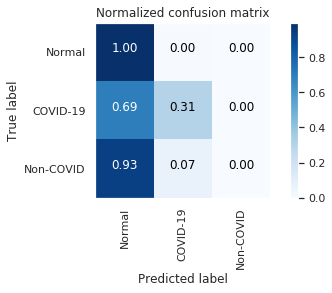

Epoch 20/70
326/326 [==============================] - 39s 119ms/step - loss: 0.4810 - accuracy: 0.7882 - val_loss: 5.3206 - val_accuracy: 0.6587

Epoch 00020: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.087989


---------------------
| Balanced Accuracy  |
---------------------

    0.5769466224011678


---------------------
|      Accuracy      |
---------------------

    0.6586538461538461


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.58      0.98      0.73       234
           1       0.80      0.75      0.78       242
           2       0.00      0.00      0.00       148

    accuracy                           0.66       624
   macro avg       0.46      0.58      0.50       624
weighted avg       0.53      0.66      0.57       624

--------------------
| Co

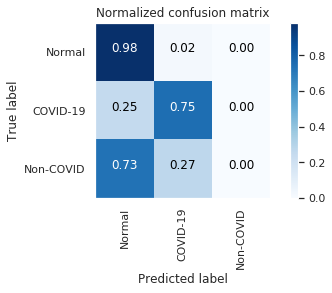

Epoch 21/70
326/326 [==============================] - 39s 119ms/step - loss: 0.4749 - accuracy: 0.7912 - val_loss: 0.5942 - val_accuracy: 0.8413

Epoch 00021: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.110248


---------------------
| Balanced Accuracy  |
---------------------

    0.8258371212916668


---------------------
|      Accuracy      |
---------------------

    0.8413461538461539


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       234
           1       0.84      0.93      0.88       242
           2       0.72      0.72      0.72       148

    accuracy                           0.84       624
   macro avg       0.83      0.83      0.83       624
weighted avg       0.85      0.84      0.84       624

--------------------
| Co

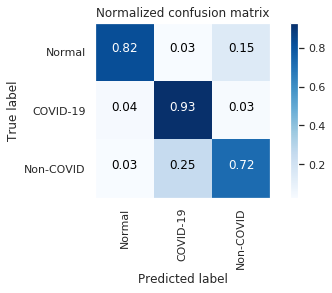

Epoch 22/70
326/326 [==============================] - 39s 118ms/step - loss: 0.4915 - accuracy: 0.7912 - val_loss: 4.5545 - val_accuracy: 0.5705

Epoch 00022: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.082759


---------------------
| Balanced Accuracy  |
---------------------

    0.5011419556874103


---------------------
|      Accuracy      |
---------------------

    0.5705128205128205


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       234
           1       0.74      0.52      0.62       242
           2       0.00      0.00      0.00       148

    accuracy                           0.57       624
   macro avg       0.42      0.50      0.43       624
weighted avg       0.48      0.57      0.49       624

--------------------
| Co

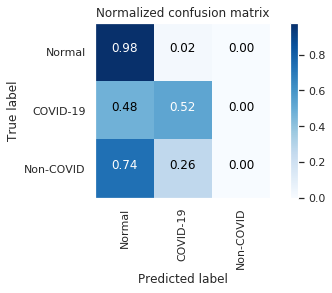

Epoch 23/70
326/326 [==============================] - 39s 119ms/step - loss: 0.4741 - accuracy: 0.7947 - val_loss: 0.3956 - val_accuracy: 0.6955

Epoch 00023: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.107556


---------------------
| Balanced Accuracy  |
---------------------

    0.7098010279828463


---------------------
|      Accuracy      |
---------------------

    0.6955128205128205


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.93      0.48      0.63       234
           1       0.83      0.83      0.83       242
           2       0.46      0.82      0.59       148

    accuracy                           0.70       624
   macro avg       0.74      0.71      0.68       624
weighted avg       0.78      0.70      0.70       624

--------------------
| Co

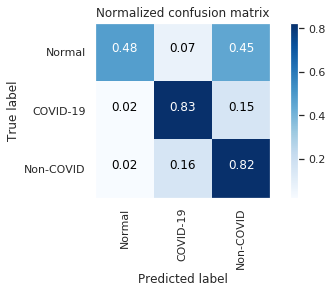

Epoch 24/70
326/326 [==============================] - 39s 118ms/step - loss: 0.4705 - accuracy: 0.7937 - val_loss: 1.1029 - val_accuracy: 0.7644

Epoch 00024: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 1s 30ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.192992


---------------------
| Balanced Accuracy  |
---------------------

    0.7281999100180917


---------------------
|      Accuracy      |
---------------------

    0.7644230769230769


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.71      0.90      0.79       234
           1       0.88      0.81      0.84       242
           2       0.68      0.47      0.56       148

    accuracy                           0.76       624
   macro avg       0.76      0.73      0.73       624
weighted avg       0.77      0.76      0.76       624

--------------------
| Co

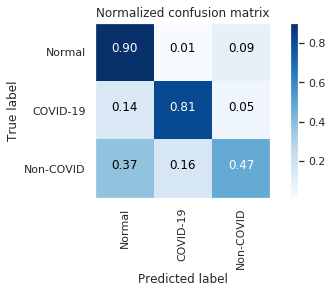

Epoch 25/70
326/326 [==============================] - 39s 118ms/step - loss: 0.4724 - accuracy: 0.7929 - val_loss: 4.2090 - val_accuracy: 0.6442

Epoch 00025: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.092206


---------------------
| Balanced Accuracy  |
---------------------

    0.5645028372301099


---------------------
|      Accuracy      |
---------------------

    0.6442307692307693


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.57      0.98      0.72       234
           1       0.78      0.71      0.75       242
           2       0.00      0.00      0.00       148

    accuracy                           0.64       624
   macro avg       0.45      0.56      0.49       624
weighted avg       0.52      0.64      0.56       624

--------------------
| Co

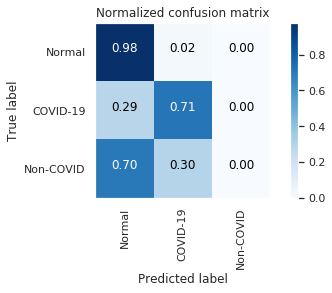

Epoch 26/70
326/326 [==============================] - 39s 120ms/step - loss: 0.4644 - accuracy: 0.7954 - val_loss: 0.9667 - val_accuracy: 0.8109

Epoch 00026: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.086262


---------------------
| Balanced Accuracy  |
---------------------

    0.7878224696406514


---------------------
|      Accuracy      |
---------------------

    0.8108974358974359


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       234
           1       0.77      0.95      0.85       242
           2       0.78      0.64      0.70       148

    accuracy                           0.81       624
   macro avg       0.81      0.79      0.79       624
weighted avg       0.82      0.81      0.81       624

--------------------
| Co

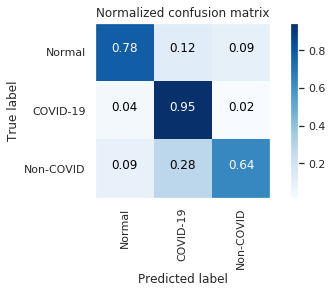

Epoch 27/70
326/326 [==============================] - 39s 119ms/step - loss: 0.4706 - accuracy: 0.7937 - val_loss: 2.2436 - val_accuracy: 0.7228

Epoch 00027: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.097540


---------------------
| Balanced Accuracy  |
---------------------

    0.6371780235416599


---------------------
|      Accuracy      |
---------------------

    0.7227564102564102


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       234
           1       0.63      0.97      0.77       242
           2       0.78      0.05      0.09       148

    accuracy                           0.72       624
   macro avg       0.76      0.64      0.58       624
weighted avg       0.75      0.72      0.65       624

--------------------
| Co

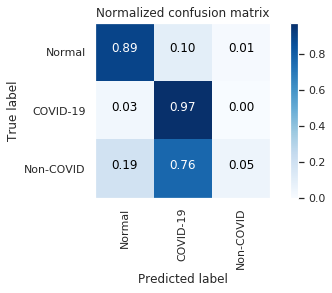

Epoch 28/70
326/326 [==============================] - 39s 120ms/step - loss: 0.4491 - accuracy: 0.8033 - val_loss: 1.3787 - val_accuracy: 0.4135

Epoch 00028: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 1s 27ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.078957


---------------------
| Balanced Accuracy  |
---------------------

    0.37383776020139653


---------------------
|      Accuracy      |
---------------------

    0.41346153846153844


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       234
           1       0.50      0.97      0.66       242
           2       0.14      0.14      0.14       148

    accuracy                           0.41       624
   macro avg       0.55      0.37      0.27       624
weighted avg       0.60      0.41      0.30       624

--------------------
| 

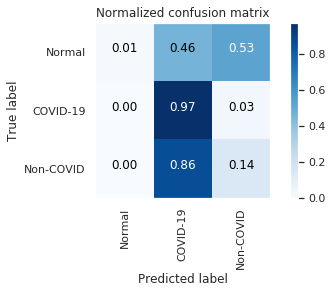

Epoch 29/70
326/326 [==============================] - 39s 120ms/step - loss: 0.4585 - accuracy: 0.7956 - val_loss: 2.9170 - val_accuracy: 0.7324

Epoch 00029: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.102123


---------------------
| Balanced Accuracy  |
---------------------

    0.6432888705615978


---------------------
|      Accuracy      |
---------------------

    0.7323717948717948


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       234
           1       0.66      0.97      0.78       242
           2       0.80      0.03      0.05       148

    accuracy                           0.73       624
   macro avg       0.76      0.64      0.57       624
weighted avg       0.76      0.73      0.65       624

--------------------
| Co

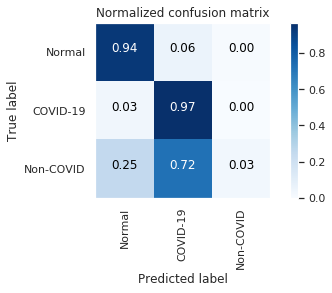

Epoch 30/70
326/326 [==============================] - 39s 118ms/step - loss: 0.4489 - accuracy: 0.8085 - val_loss: 1.9342 - val_accuracy: 0.6186

Epoch 00030: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 1s 29ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.131575


---------------------
| Balanced Accuracy  |
---------------------

    0.546193841648387


---------------------
|      Accuracy      |
---------------------

    0.6185897435897436


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.89      0.60      0.72       234
           1       0.52      0.98      0.68       242
           2       0.60      0.06      0.11       148

    accuracy                           0.62       624
   macro avg       0.67      0.55      0.50       624
weighted avg       0.68      0.62      0.56       624

--------------------
| Con

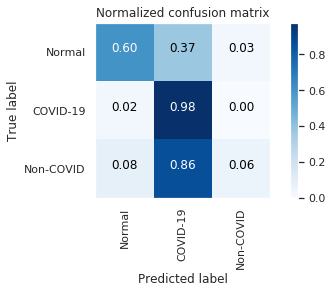

Epoch 31/70
326/326 [==============================] - 39s 120ms/step - loss: 0.4475 - accuracy: 0.8031 - val_loss: 0.9087 - val_accuracy: 0.7660

Epoch 00031: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.087549


---------------------
| Balanced Accuracy  |
---------------------

    0.7243355879719516


---------------------
|      Accuracy      |
---------------------

    0.7660256410256411


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       234
           1       0.67      0.98      0.80       242
           2       0.69      0.45      0.54       148

    accuracy                           0.77       624
   macro avg       0.79      0.72      0.73       624
weighted avg       0.80      0.77      0.76       624

--------------------
| Co

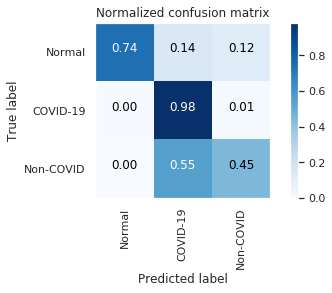

Epoch 32/70
326/326 [==============================] - 39s 120ms/step - loss: 0.4418 - accuracy: 0.8071 - val_loss: 0.5695 - val_accuracy: 0.8574

Epoch 00032: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.088845


---------------------
| Balanced Accuracy  |
---------------------

    0.843938343938344


---------------------
|      Accuracy      |
---------------------

    0.8573717948717948


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.98      0.82      0.90       234
           1       0.84      0.95      0.89       242
           2       0.73      0.76      0.74       148

    accuracy                           0.86       624
   macro avg       0.85      0.84      0.84       624
weighted avg       0.87      0.86      0.86       624

--------------------
| Con

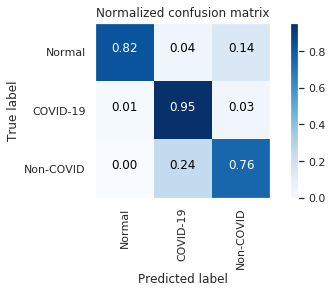

Epoch 33/70
326/326 [==============================] - 39s 119ms/step - loss: 0.4473 - accuracy: 0.8041 - val_loss: 3.6127 - val_accuracy: 0.6474

Epoch 00033: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 1s 30ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.222887


---------------------
| Balanced Accuracy  |
---------------------

    0.5770692816147361


---------------------
|      Accuracy      |
---------------------

    0.6474358974358975


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       234
           1       0.87      0.66      0.75       242
           2       0.92      0.07      0.14       148

    accuracy                           0.65       624
   macro avg       0.78      0.58      0.53       624
weighted avg       0.76      0.65      0.59       624

--------------------
| Co

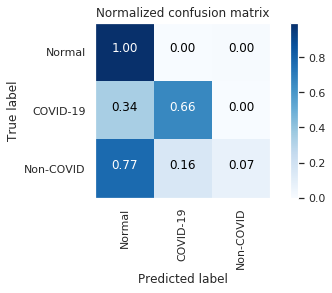

Epoch 34/70
326/326 [==============================] - 39s 119ms/step - loss: 0.4445 - accuracy: 0.8031 - val_loss: 0.4952 - val_accuracy: 0.8285

Epoch 00034: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.102479


---------------------
| Balanced Accuracy  |
---------------------

    0.8191250691250692


---------------------
|      Accuracy      |
---------------------

    0.8285256410256411


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       234
           1       0.82      0.95      0.88       242
           2       0.67      0.76      0.72       148

    accuracy                           0.83       624
   macro avg       0.83      0.82      0.81       624
weighted avg       0.85      0.83      0.83       624

--------------------
| Co

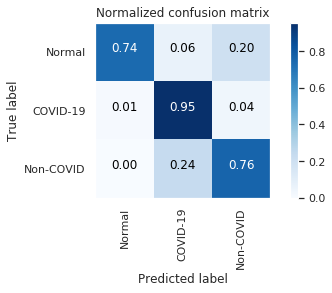

Epoch 35/70
326/326 [==============================] - 39s 121ms/step - loss: 0.4510 - accuracy: 0.8006 - val_loss: 0.9486 - val_accuracy: 0.8253

Epoch 00035: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.095651


---------------------
| Balanced Accuracy  |
---------------------

    0.7822911913821006


---------------------
|      Accuracy      |
---------------------

    0.8253205128205128


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       234
           1       0.78      0.96      0.86       242
           2       0.81      0.49      0.61       148

    accuracy                           0.83       624
   macro avg       0.83      0.78      0.79       624
weighted avg       0.83      0.83      0.81       624

--------------------
| Co

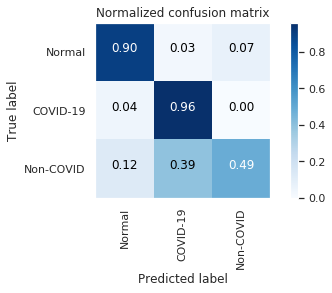

Epoch 36/70
326/326 [==============================] - 39s 118ms/step - loss: 0.4334 - accuracy: 0.8119 - val_loss: 3.5512 - val_accuracy: 0.6442

Epoch 00036: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 1s 29ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.135581


---------------------
| Balanced Accuracy  |
---------------------

    0.5764680764680764


---------------------
|      Accuracy      |
---------------------

    0.6442307692307693


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.56      0.95      0.70       234
           1       0.80      0.68      0.74       242
           2       0.78      0.09      0.17       148

    accuracy                           0.64       624
   macro avg       0.71      0.58      0.54       624
weighted avg       0.70      0.64      0.59       624

--------------------
| Co

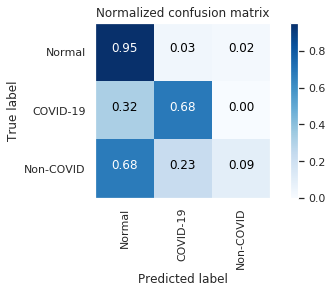

Epoch 37/70
326/326 [==============================] - 39s 119ms/step - loss: 0.4345 - accuracy: 0.8112 - val_loss: 1.0215 - val_accuracy: 0.8558

Epoch 00037: val_accuracy did not improve from 0.88141
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.099812


---------------------
| Balanced Accuracy  |
---------------------

    0.8211335938608665


---------------------
|      Accuracy      |
---------------------

    0.8557692307692307


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       234
           1       0.84      0.94      0.89       242
           2       0.88      0.58      0.70       148

    accuracy                           0.86       624
   macro avg       0.86      0.82      0.83       624
weighted avg       0.86      0.86      0.85       624

--------------------
| Co

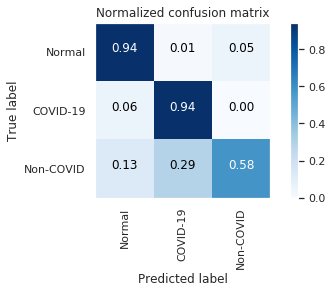

Epoch 38/70
326/326 [==============================] - 39s 120ms/step - loss: 0.4257 - accuracy: 0.8117 - val_loss: 0.7500 - val_accuracy: 0.8862

Epoch 00038: val_accuracy improved from 0.88141 to 0.88622, saving model to Model/best_model_multiclass_128.h5
Predicting test data
39/39 [==============================] - 1s 29ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.134728


---------------------
| Balanced Accuracy  |
---------------------

    0.8660800024436388


---------------------
|      Accuracy      |
---------------------

    0.8862179487179487


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       234
           1       0.86      0.97      0.91       242
           2       0.84      0.73      0.78       148

    accuracy                           0.89       624
   macro avg       0.88      0.87      0.87       624
weighted avg       0.89 

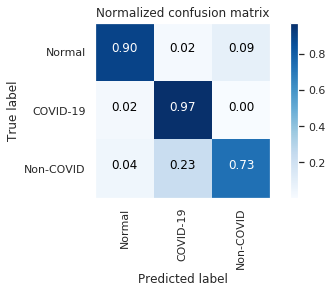

Epoch 39/70
326/326 [==============================] - 39s 119ms/step - loss: 0.4223 - accuracy: 0.8173 - val_loss: 0.6677 - val_accuracy: 0.6939

Epoch 00039: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.095045


---------------------
| Balanced Accuracy  |
---------------------

    0.7002005183823367


---------------------
|      Accuracy      |
---------------------

    0.6939102564102564


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      0.37      0.54       234
           1       0.71      0.96      0.81       242
           2       0.55      0.77      0.64       148

    accuracy                           0.69       624
   macro avg       0.75      0.70      0.66       624
weighted avg       0.78      0.69      0.67       624

--------------------
| Co

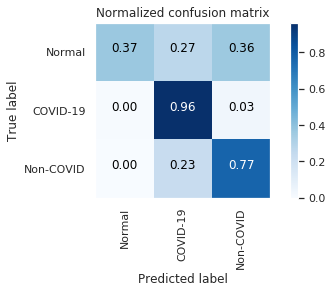

Epoch 40/70
326/326 [==============================] - 39s 119ms/step - loss: 0.4160 - accuracy: 0.8209 - val_loss: 0.5553 - val_accuracy: 0.5785

Epoch 00040: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 27ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.071159


---------------------
| Balanced Accuracy  |
---------------------

    0.5947691174963903


---------------------
|      Accuracy      |
---------------------

    0.5785256410256411


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.98      0.20      0.33       234
           1       0.77      0.85      0.81       242
           2       0.35      0.74      0.48       148

    accuracy                           0.58       624
   macro avg       0.70      0.59      0.54       624
weighted avg       0.75      0.58      0.55       624

--------------------
| Co

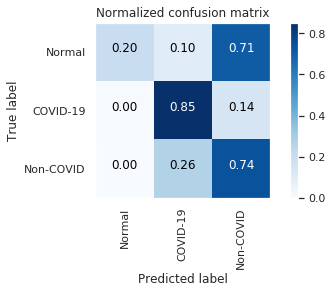

Epoch 41/70
326/326 [==============================] - 39s 119ms/step - loss: 0.4242 - accuracy: 0.8087 - val_loss: 0.7945 - val_accuracy: 0.8558

Epoch 00041: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.093139


---------------------
| Balanced Accuracy  |
---------------------

    0.8307840580567855


---------------------
|      Accuracy      |
---------------------

    0.8557692307692307


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       234
           1       0.80      0.97      0.88       242
           2       0.82      0.66      0.73       148

    accuracy                           0.86       624
   macro avg       0.86      0.83      0.84       624
weighted avg       0.86      0.86      0.85       624

--------------------
| Co

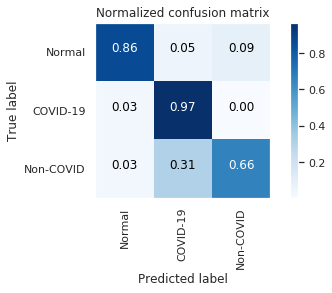

Epoch 42/70
326/326 [==============================] - 39s 121ms/step - loss: 0.4290 - accuracy: 0.8152 - val_loss: 0.8877 - val_accuracy: 0.7885

Epoch 00042: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.084360


---------------------
| Balanced Accuracy  |
---------------------

    0.7616268525359434


---------------------
|      Accuracy      |
---------------------

    0.7884615384615384


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.75      0.95      0.84       234
           1       0.90      0.77      0.83       242
           2       0.69      0.57      0.62       148

    accuracy                           0.79       624
   macro avg       0.78      0.76      0.76       624
weighted avg       0.79      0.79      0.78       624

--------------------
| Co

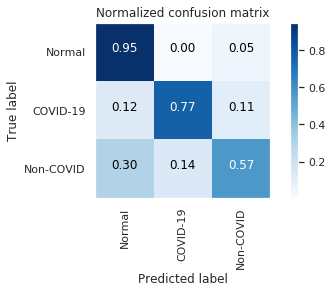

Epoch 43/70
326/326 [==============================] - 39s 119ms/step - loss: 0.4259 - accuracy: 0.8119 - val_loss: 8.8073 - val_accuracy: 0.4792

Epoch 00043: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.082290


---------------------
| Balanced Accuracy  |
---------------------

    0.42277083186174097


---------------------
|      Accuracy      |
---------------------

    0.4791666666666667


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.42      0.99      0.59       234
           1       0.86      0.28      0.42       242
           2       0.00      0.00      0.00       148

    accuracy                           0.48       624
   macro avg       0.43      0.42      0.34       624
weighted avg       0.49      0.48      0.39       624

--------------------
| C

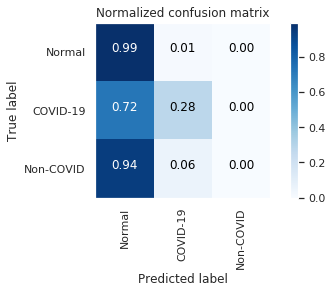

Epoch 44/70
326/326 [==============================] - 39s 120ms/step - loss: 0.4143 - accuracy: 0.8209 - val_loss: 4.3064 - val_accuracy: 0.6090

Epoch 00044: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.104791


---------------------
| Balanced Accuracy  |
---------------------

    0.5387623796714706


---------------------
|      Accuracy      |
---------------------

    0.6089743589743589


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.52      1.00      0.69       234
           1       0.84      0.59      0.69       242
           2       0.50      0.03      0.06       148

    accuracy                           0.61       624
   macro avg       0.62      0.54      0.48       624
weighted avg       0.64      0.61      0.54       624

--------------------
| Co

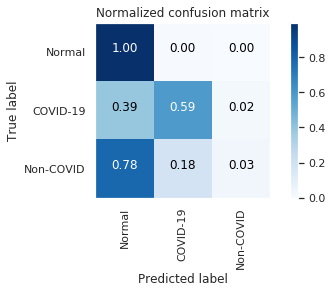

Epoch 45/70
326/326 [==============================] - 39s 120ms/step - loss: 0.4143 - accuracy: 0.8209 - val_loss: 1.6704 - val_accuracy: 0.7596

Epoch 00045: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 27ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.074410


---------------------
| Balanced Accuracy  |
---------------------

    0.7219412673958129


---------------------
|      Accuracy      |
---------------------

    0.7596153846153846


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       234
           1       0.79      0.84      0.81       242
           2       0.69      0.46      0.55       148

    accuracy                           0.76       624
   macro avg       0.75      0.72      0.72       624
weighted avg       0.75      0.76      0.75       624

--------------------
| Co

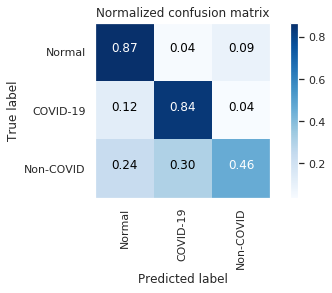

Epoch 46/70
326/326 [==============================] - 39s 118ms/step - loss: 0.4079 - accuracy: 0.8221 - val_loss: 1.0507 - val_accuracy: 0.8205

Epoch 00046: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.108060


---------------------
| Balanced Accuracy  |
---------------------

    0.7901984947439492


---------------------
|      Accuracy      |
---------------------

    0.8205128205128205


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.98      0.80      0.88       234
           1       0.74      0.98      0.84       242
           2       0.78      0.59      0.67       148

    accuracy                           0.82       624
   macro avg       0.83      0.79      0.80       624
weighted avg       0.84      0.82      0.82       624

--------------------
| Co

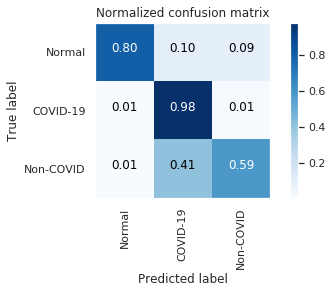

Epoch 47/70
326/326 [==============================] - 39s 119ms/step - loss: 0.4002 - accuracy: 0.8225 - val_loss: 0.5485 - val_accuracy: 0.8734

Epoch 00047: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 27ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.080407


---------------------
| Balanced Accuracy  |
---------------------

    0.8666963212417759


---------------------
|      Accuracy      |
---------------------

    0.8733974358974359


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.96      0.84      0.90       234
           1       0.88      0.93      0.91       242
           2       0.75      0.82      0.78       148

    accuracy                           0.87       624
   macro avg       0.86      0.87      0.86       624
weighted avg       0.88      0.87      0.87       624

--------------------
| Co

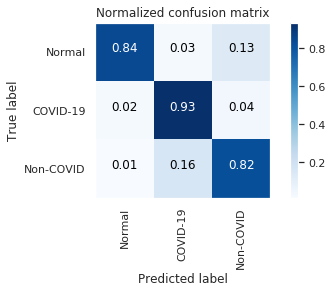

Epoch 48/70
326/326 [==============================] - 39s 119ms/step - loss: 0.4083 - accuracy: 0.8204 - val_loss: 1.3169 - val_accuracy: 0.7340

Epoch 00048: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.122843


---------------------
| Balanced Accuracy  |
---------------------

    0.656988361533816


---------------------
|      Accuracy      |
---------------------

    0.7339743589743589


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       234
           1       0.62      0.98      0.76       242
           2       0.73      0.13      0.22       148

    accuracy                           0.73       624
   macro avg       0.76      0.66      0.63       624
weighted avg       0.77      0.73      0.68       624

--------------------
| Con

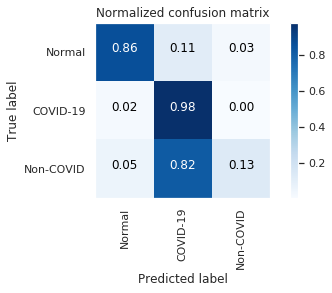

Epoch 49/70
326/326 [==============================] - 39s 120ms/step - loss: 0.4018 - accuracy: 0.8286 - val_loss: 0.4535 - val_accuracy: 0.7532

Epoch 00049: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.084852


---------------------
| Balanced Accuracy  |
---------------------

    0.7623943078488534


---------------------
|      Accuracy      |
---------------------

    0.7532051282051282


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       234
           1       0.88      0.57      0.69       242
           2       0.52      0.81      0.63       148

    accuracy                           0.75       624
   macro avg       0.77      0.76      0.74       624
weighted avg       0.80      0.75      0.76       624

--------------------
| Co

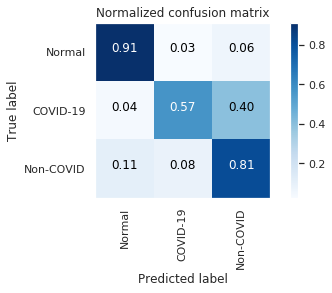

Epoch 50/70
326/326 [==============================] - 39s 119ms/step - loss: 0.4007 - accuracy: 0.8230 - val_loss: 2.6036 - val_accuracy: 0.6875

Epoch 00050: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.087199


---------------------
| Balanced Accuracy  |
---------------------

    0.6261413988686716


---------------------
|      Accuracy      |
---------------------

    0.6875


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.62      0.97      0.75       234
           1       0.78      0.71      0.75       242
           2       0.88      0.19      0.31       148

    accuracy                           0.69       624
   macro avg       0.76      0.63      0.60       624
weighted avg       0.74      0.69      0.65       624

--------------------
| Confusion Matr

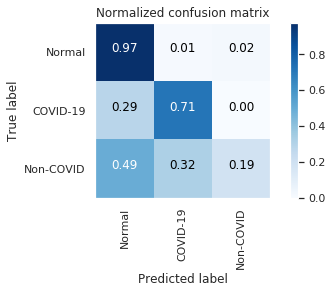

Epoch 51/70
326/326 [==============================] - 39s 119ms/step - loss: 0.3963 - accuracy: 0.8296 - val_loss: 0.9094 - val_accuracy: 0.8590

Epoch 00051: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.099355


---------------------
| Balanced Accuracy  |
---------------------

    0.8276975322429868


---------------------
|      Accuracy      |
---------------------

    0.8589743589743589


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       234
           1       0.80      0.98      0.88       242
           2       0.82      0.61      0.70       148

    accuracy                           0.86       624
   macro avg       0.86      0.83      0.84       624
weighted avg       0.86      0.86      0.85       624

--------------------
| Co

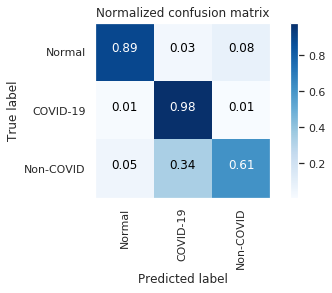

Epoch 52/70
326/326 [==============================] - 39s 120ms/step - loss: 0.3964 - accuracy: 0.8284 - val_loss: 0.9169 - val_accuracy: 0.3397

Epoch 00052: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 27ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.075374


---------------------
| Balanced Accuracy  |
---------------------

    0.3541917632826724


---------------------
|      Accuracy      |
---------------------

    0.33974358974358976


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.09      0.16       234
           1       0.51      0.50      0.51       242
           2       0.19      0.47      0.27       148

    accuracy                           0.34       624
   macro avg       0.57      0.35      0.31       624
weighted avg       0.62      0.34      0.32       624

--------------------
| C

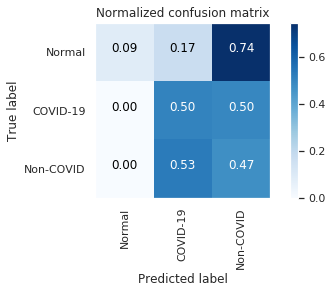

Epoch 53/70
326/326 [==============================] - 39s 120ms/step - loss: 0.3858 - accuracy: 0.8355 - val_loss: 0.8481 - val_accuracy: 0.7532

Epoch 00053: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.091005


---------------------
| Balanced Accuracy  |
---------------------

    0.7328526873981419


---------------------
|      Accuracy      |
---------------------

    0.7532051282051282


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      0.61      0.76       234
           1       0.73      0.98      0.84       242
           2       0.58      0.61      0.59       148

    accuracy                           0.75       624
   macro avg       0.77      0.73      0.73       624
weighted avg       0.79      0.75      0.75       624

--------------------
| Co

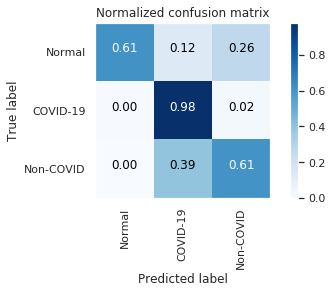

Epoch 54/70
326/326 [==============================] - 39s 118ms/step - loss: 0.3982 - accuracy: 0.8307 - val_loss: 2.6409 - val_accuracy: 0.7468

Epoch 00054: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 29ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.123737


---------------------
| Balanced Accuracy  |
---------------------

    0.6611700702609794


---------------------
|      Accuracy      |
---------------------

    0.7467948717948718


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       234
           1       0.66      0.96      0.78       242
           2       0.83      0.07      0.13       148

    accuracy                           0.75       624
   macro avg       0.78      0.66      0.60       624
weighted avg       0.78      0.75      0.67       624

--------------------
| Co

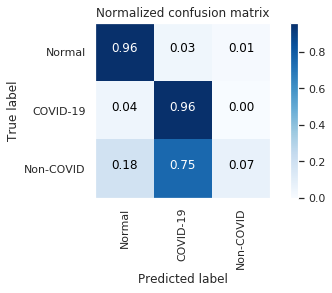

Epoch 55/70
326/326 [==============================] - 39s 118ms/step - loss: 0.3949 - accuracy: 0.8259 - val_loss: 2.8948 - val_accuracy: 0.7452

Epoch 00055: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.085691


---------------------
| Balanced Accuracy  |
---------------------

    0.6748062429880611


---------------------
|      Accuracy      |
---------------------

    0.7451923076923077


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.69      0.97      0.81       234
           1       0.81      0.87      0.84       242
           2       0.77      0.18      0.30       148

    accuracy                           0.75       624
   macro avg       0.76      0.67      0.65       624
weighted avg       0.76      0.75      0.70       624

--------------------
| Co

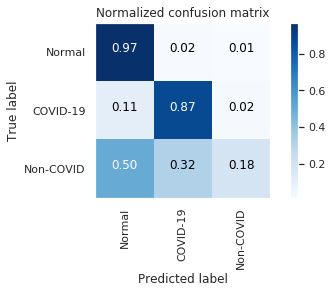

Epoch 56/70
326/326 [==============================] - 39s 120ms/step - loss: 0.3949 - accuracy: 0.8290 - val_loss: 5.0763 - val_accuracy: 0.6891

Epoch 00056: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.107430


---------------------
| Balanced Accuracy  |
---------------------

    0.6026465117374208


---------------------
|      Accuracy      |
---------------------

    0.6891025641025641


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.70      0.94      0.80       234
           1       0.68      0.87      0.76       242
           2       0.00      0.00      0.00       148

    accuracy                           0.69       624
   macro avg       0.46      0.60      0.52       624
weighted avg       0.53      0.69      0.60       624

--------------------
| Co

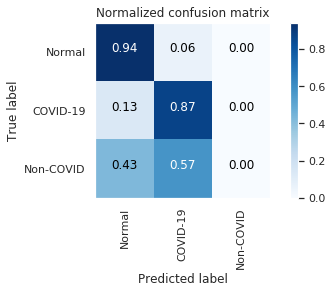

Epoch 57/70
326/326 [==============================] - 39s 119ms/step - loss: 0.3818 - accuracy: 0.8267 - val_loss: 0.6226 - val_accuracy: 0.8606

Epoch 00057: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.121224


---------------------
| Balanced Accuracy  |
---------------------

    0.8462421416966871


---------------------
|      Accuracy      |
---------------------

    0.8605769230769231


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       234
           1       0.84      0.93      0.88       242
           2       0.79      0.75      0.77       148

    accuracy                           0.86       624
   macro avg       0.85      0.85      0.85       624
weighted avg       0.86      0.86      0.86       624

--------------------
| Co

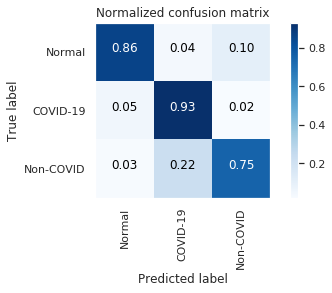

Epoch 58/70
326/326 [==============================] - 38s 118ms/step - loss: 0.3832 - accuracy: 0.8351 - val_loss: 0.7997 - val_accuracy: 0.6282

Epoch 00058: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.090082


---------------------
| Balanced Accuracy  |
---------------------

    0.6226164180709636


---------------------
|      Accuracy      |
---------------------

    0.6282051282051282


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.98      0.28      0.43       234
           1       0.67      0.98      0.80       242
           2       0.44      0.61      0.51       148

    accuracy                           0.63       624
   macro avg       0.70      0.62      0.58       624
weighted avg       0.73      0.63      0.59       624

--------------------
| Co

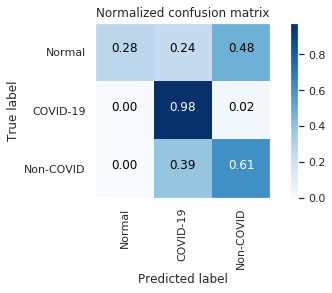

Epoch 59/70
326/326 [==============================] - 39s 120ms/step - loss: 0.3806 - accuracy: 0.8349 - val_loss: 0.7656 - val_accuracy: 0.7660

Epoch 00059: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.094780


---------------------
| Balanced Accuracy  |
---------------------

    0.754355436173618


---------------------
|      Accuracy      |
---------------------

    0.7660256410256411


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       234
           1       0.81      0.67      0.74       242
           2       0.55      0.66      0.60       148

    accuracy                           0.77       624
   macro avg       0.75      0.75      0.75       624
weighted avg       0.78      0.77      0.77       624

--------------------
| Con

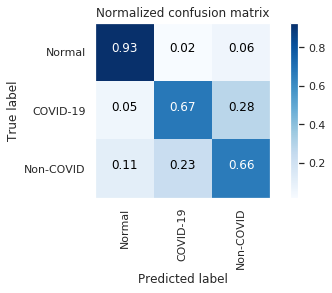

Epoch 60/70
326/326 [==============================] - 39s 118ms/step - loss: 0.3781 - accuracy: 0.8324 - val_loss: 3.8463 - val_accuracy: 0.7035

Epoch 00060: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 29ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.149096


---------------------
| Balanced Accuracy  |
---------------------

    0.6179303906576633


---------------------
|      Accuracy      |
---------------------

    0.7035256410256411


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.83      0.88      0.86       234
           1       0.62      0.94      0.75       242
           2       0.50      0.03      0.05       148

    accuracy                           0.70       624
   macro avg       0.65      0.62      0.55       624
weighted avg       0.67      0.70      0.62       624

--------------------
| Co

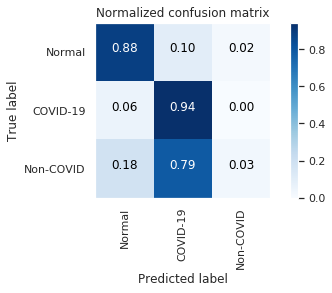

Epoch 61/70
326/326 [==============================] - 39s 119ms/step - loss: 0.3810 - accuracy: 0.8355 - val_loss: 1.1966 - val_accuracy: 0.8558

Epoch 00061: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.091165


---------------------
| Balanced Accuracy  |
---------------------

    0.8238052101688466


---------------------
|      Accuracy      |
---------------------

    0.8557692307692307


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.85      0.94      0.90       234
           1       0.86      0.93      0.89       242
           2       0.85      0.60      0.70       148

    accuracy                           0.86       624
   macro avg       0.85      0.82      0.83       624
weighted avg       0.86      0.86      0.85       624

--------------------
| Co

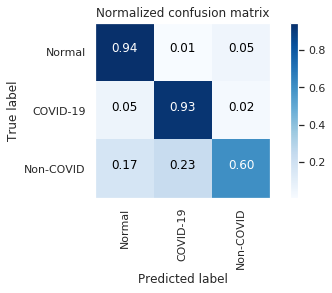

Epoch 62/70
326/326 [==============================] - 39s 119ms/step - loss: 0.3816 - accuracy: 0.8330 - val_loss: 1.4264 - val_accuracy: 0.8221

Epoch 00062: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 27ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.065852


---------------------
| Balanced Accuracy  |
---------------------

    0.7798189161825526


---------------------
|      Accuracy      |
---------------------

    0.8221153846153846


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       234
           1       0.80      0.93      0.86       242
           2       0.81      0.49      0.61       148

    accuracy                           0.82       624
   macro avg       0.82      0.78      0.78       624
weighted avg       0.82      0.82      0.81       624

--------------------
| Co

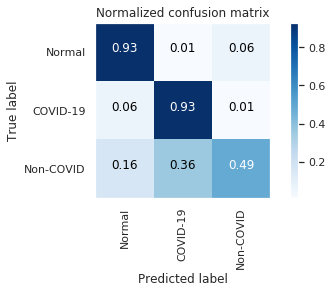

Epoch 63/70
326/326 [==============================] - 39s 120ms/step - loss: 0.3681 - accuracy: 0.8399 - val_loss: 0.5666 - val_accuracy: 0.8862

Epoch 00063: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 29ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.145684


---------------------
| Balanced Accuracy  |
---------------------

    0.8791084472902654


---------------------
|      Accuracy      |
---------------------

    0.8862179487179487


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       234
           1       0.91      0.92      0.91       242
           2       0.80      0.83      0.82       148

    accuracy                           0.89       624
   macro avg       0.88      0.88      0.88       624
weighted avg       0.89      0.89      0.89       624

--------------------
| Co

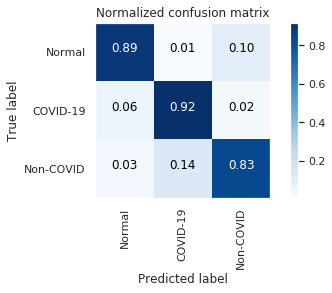

Epoch 64/70
326/326 [==============================] - 39s 119ms/step - loss: 0.3756 - accuracy: 0.8332 - val_loss: 0.5965 - val_accuracy: 0.4455

Epoch 00064: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.082305


---------------------
| Balanced Accuracy  |
---------------------

    0.49291997019269745


---------------------
|      Accuracy      |
---------------------

    0.44551282051282054


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.98      0.38      0.54       234
           1       0.61      0.29      0.39       242
           2       0.29      0.82      0.43       148

    accuracy                           0.45       624
   macro avg       0.62      0.49      0.45       624
weighted avg       0.67      0.45      0.46       624

--------------------
| 

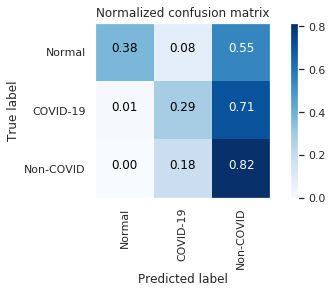

Epoch 65/70
326/326 [==============================] - 39s 120ms/step - loss: 0.3673 - accuracy: 0.8397 - val_loss: 0.5762 - val_accuracy: 0.7484

Epoch 00065: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 27ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.073366


---------------------
| Balanced Accuracy  |
---------------------

    0.7510226373862737


---------------------
|      Accuracy      |
---------------------

    0.7483974358974359


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      0.49      0.66       234
           1       0.82      0.97      0.89       242
           2       0.53      0.79      0.63       148

    accuracy                           0.75       624
   macro avg       0.78      0.75      0.73       624
weighted avg       0.81      0.75      0.74       624

--------------------
| Co

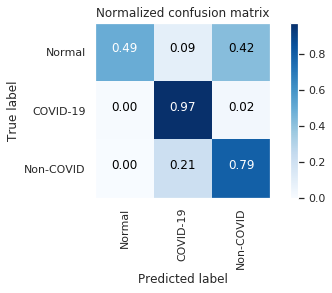

Epoch 66/70
326/326 [==============================] - 39s 119ms/step - loss: 0.3723 - accuracy: 0.8376 - val_loss: 4.3066 - val_accuracy: 0.6683

Epoch 00066: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.115862


---------------------
| Balanced Accuracy  |
---------------------

    0.5912878867424322


---------------------
|      Accuracy      |
---------------------

    0.6682692307692307


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.62      0.98      0.76       234
           1       0.75      0.75      0.75       242
           2       0.54      0.05      0.09       148

    accuracy                           0.67       624
   macro avg       0.64      0.59      0.53       624
weighted avg       0.65      0.67      0.60       624

--------------------
| Co

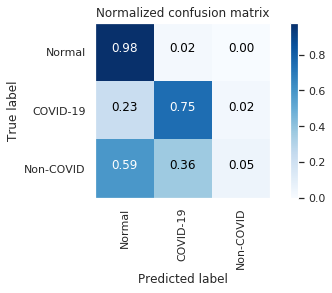

Epoch 67/70
326/326 [==============================] - 39s 118ms/step - loss: 0.3667 - accuracy: 0.8405 - val_loss: 1.6083 - val_accuracy: 0.7580

Epoch 00067: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.085681


---------------------
| Balanced Accuracy  |
---------------------

    0.7038005901642266


---------------------
|      Accuracy      |
---------------------

    0.7580128205128205


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       234
           1       0.71      0.93      0.80       242
           2       0.75      0.33      0.46       148

    accuracy                           0.76       624
   macro avg       0.76      0.70      0.70       624
weighted avg       0.76      0.76      0.73       624

--------------------
| Co

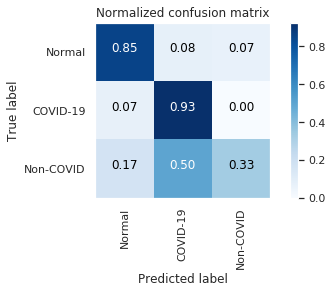

Epoch 68/70
326/326 [==============================] - 39s 118ms/step - loss: 0.3661 - accuracy: 0.8372 - val_loss: 5.8669 - val_accuracy: 0.7115

Epoch 00068: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.110624


---------------------
| Balanced Accuracy  |
---------------------

    0.6273676728222183


---------------------
|      Accuracy      |
---------------------

    0.7115384615384616


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.67      0.96      0.79       234
           1       0.76      0.88      0.82       242
           2       0.86      0.04      0.08       148

    accuracy                           0.71       624
   macro avg       0.76      0.63      0.56       624
weighted avg       0.75      0.71      0.63       624

--------------------
| Co

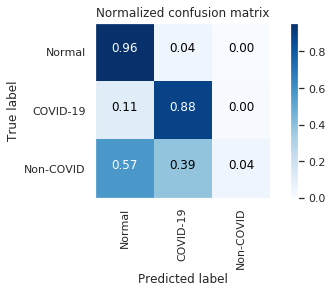

Epoch 69/70
326/326 [==============================] - 39s 118ms/step - loss: 0.3641 - accuracy: 0.8426 - val_loss: 2.0970 - val_accuracy: 0.7436

Epoch 00069: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.103993


---------------------
| Balanced Accuracy  |
---------------------

    0.7102663693572785


---------------------
|      Accuracy      |
---------------------

    0.7435897435897436


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.72      0.98      0.83       234
           1       0.92      0.69      0.78       242
           2       0.56      0.47      0.51       148

    accuracy                           0.74       624
   macro avg       0.73      0.71      0.71       624
weighted avg       0.76      0.74      0.74       624

--------------------
| Co

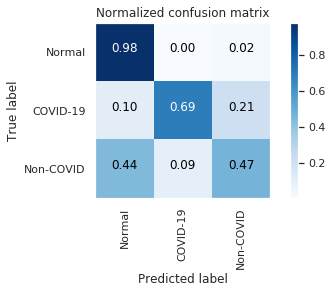

Epoch 70/70
326/326 [==============================] - 39s 120ms/step - loss: 0.3586 - accuracy: 0.8462 - val_loss: 0.7261 - val_accuracy: 0.7869

Epoch 00070: val_accuracy did not improve from 0.88622
Predicting test data
39/39 [==============================] - 1s 28ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.081201


---------------------
| Balanced Accuracy  |
---------------------

    0.7871016280107189


---------------------
|      Accuracy      |
---------------------

    0.7868589743589743


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      0.61      0.75       234
           1       0.83      0.95      0.88       242
           2       0.59      0.80      0.68       148

    accuracy                           0.79       624
   macro avg       0.80      0.79      0.77       624
weighted avg       0.83      0.79      0.79       624

--------------------
| Co

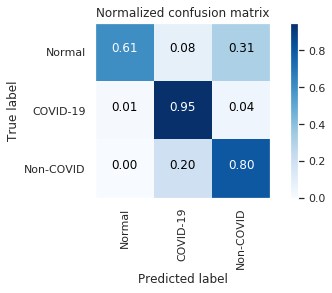

In [123]:
history = full_model.fit_generator(train_generator,
                              steps_per_epoch = len(train_data) // 16,
                              validation_data=val_generator,
                              validation_steps= len(test_data)// 16,
                              class_weight =class_weights,
                              epochs = 70,
                              callbacks = get_callbacks(),
                              verbose = 1
                              )

Predicting test data
39/39 [==============================] - 3s 70ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:06.180293


---------------------
| Balanced Accuracy  |
---------------------

    0.8660800024436388


---------------------
|      Accuracy      |
---------------------

    0.8862179487179487


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       234
           1       0.86      0.97      0.91       242
           2       0.84      0.73      0.78       148

    accuracy                           0.89       624
   macro avg       0.88      0.87      0.87       624
weighted avg       0.89      0.89      0.88       624

--------------------
| Confusion Matrix |
--------------------

 [[210   4  20]
 [  6 235   1]
 [  6  34 108]]


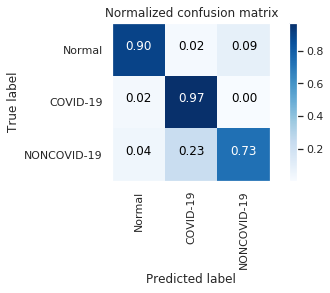

In [125]:
best_model = load_model('/kaggle/working/Model/best_model_multiclass_128.h5')
test_model(best_model, 
           val_generator,
           y_test = np.argmax(test_label, axis = 1),
           class_labels = ['Normal', 'COVID-19', 'NONCOVID-19'])